In [79]:
# dependencies
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import h5py
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm 
import scipy.stats as st
from scipy.stats import zscore
import numpy.random as npr
import ssm
import seaborn as sns
from ssm.util import one_hot, find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
from datetime import date

from postProcessing import * #my module
from plottingfunctions import * #my module
from commonFunctions import * #my module

#to add to filenames as datestring
today = date.today()
datestring = today.strftime("%m%d%y")

npr.seed(0)

sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "maroon",
    "slate",
    "light violet",
    "golden yellow",
    "bright pink",
    "bright turquoise"
    ]

genotype_colors = sns.xkcd_palette(color_names)

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

sns.set(palette="colorblind")
default_colors = sns.color_palette("colorblind")

# sns.set(palette="bright")
# default_colors = sns.color_palette("bright")


# Speficy whether or not to save figures
saveFigures = True

#load style params
#locate data directory
dataDir = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/LAWNLEAVINGPROCESSEDDATA/ssm/notebooks'
figpath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/MANUSCRIPT/figures/checkScriptVersion/Figure2'

plt.style.use(os.path.join(dataDir,'../styleparams/presentation_smallerfonts.mplstyle'))


#used for all new data loaded in
binSize = 30
minFillLen = binSize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
genotype_colors

[(0.21568627450980393, 0.47058823529411764, 0.7490196078431373),
 (0.8980392156862745, 0.0, 0.0),
 (0.996078431372549, 0.7019607843137254, 0.03137254901960784),
 (0.4823529411764706, 0.6980392156862745, 0.4549019607843137),
 (0.5098039215686274, 0.37254901960784315, 0.5294117647058824),
 (0.9764705882352941, 0.45098039215686275, 0.023529411764705882),
 (0.396078431372549, 0.0, 0.12941176470588237),
 (0.3176470588235294, 0.396078431372549, 0.4470588235294118),
 (0.8392156862745098, 0.7058823529411765, 0.9882352941176471),
 (0.996078431372549, 0.7764705882352941, 0.08235294117647059),
 (0.996078431372549, 0.00392156862745098, 0.6941176470588235),
 (0.058823529411764705, 0.996078431372549, 0.9764705882352941)]

In [81]:
#Load PD1074 HMM models and scalers
import pickle

processDataPath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/LAWNLEAVINGPROCESSEDDATA/MATFILEDATA/Pickles'

#Load PD1074 scalers
with open(os.path.join(processDataPath,'PD1074_scalers_062321.pkl'),'rb') as f:  # Python 3: open(..., 'rb')
    Scalers = pickle.load(f)
    
#load HMM Models
with open(os.path.join(processDataPath,'HMM_OnLawnOnly_ForwardFeaturesOnly_noQuirk_AR_062321.pkl'),'rb') as f:
    obs_dim,N_iters,num_states,kappa,arHMMs_ALL, arHMMs_logLike_ALL,\
                 Obs_train_forHMM, Obs_test_forHMM, \
                 Choice_train_forHMM, Choice_test_forHMM = pickle.load(f)

arHMM_model = arHMMs_ALL[4][2] #PD1074 K=4, KAPPA = 25,000


In [82]:
#load new PD1074 od2 LL centroid RD_hmm to be used as exog
import pickle

# RD_hmm_Cent_exog = PD1074_od2_LL_Data['RD_hmm_endog_Cent']

processDataPath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/LAWNLEAVINGPROCESSEDDATA/MATFILEDATA/Pickles'
# with open(os.path.join(processDataPath,'PD1074_od2_LL_Data_Centroid_RoamingDwellingHMM_081721.pkl'),'wb') as f:  # Python 3: open(..., 'rb')
#     pickle.dump(RD_hmm_Cent_exog,f)
    
with open(os.path.join(processDataPath,'PD1074_od2_LL_Data_Centroid_RoamingDwellingHMM_081721.pkl'),'rb') as f:  # Python 3: open(..., 'rb')
    RD_hmm_Cent_exog = pickle.load(f)



In [83]:
#load or save pre-processed WILDTYPE data (one Pickle for all Data now)
import pickle
#save and load binned data for mutants
#import 10 sec binned data and pca

processDataPath = '/Users/eliasscheer/Dropbox/ROCKEFELLER/BARGMANN_LAB_LYFE/LAWNLEAVINGPROCESSEDDATA/MATFILEDATA/Pickles'

with open(os.path.join(processDataPath,'WildType_022022.pkl'),'rb') as f:  # Python 3: open(..., 'rb')
    bins,binSize,wildtype = pickle.load(f)
    
with open(os.path.join(processDataPath,'UniformAndOtherDensity_022022.pkl'),'rb') as f:  # Python 3: open(..., 'rb')
    bins,binSize,OtherDensity = pickle.load(f)

In [84]:
Data = wildtype['PD1074_od2_Data']
genotypes = 'wild type'

In [85]:
Data['videoname'].shape

(1443, 1)

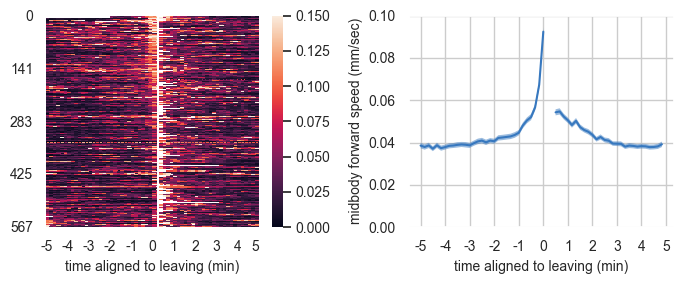

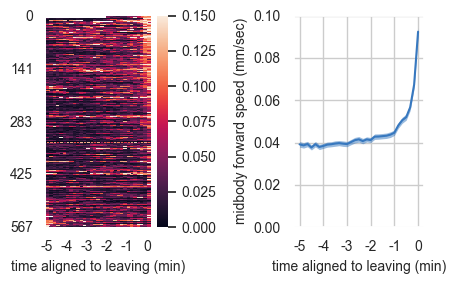

In [86]:
#Midbody Forward Speed Aligned to Lawn Leaving:
binsPerMin = 6
numMins = 5
binTimeBefore = (numMins*binsPerMin) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = (numMins*binsPerMin) # X minutes after
binLawnExit = Data['bin_LawnExit_mostRecent']
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],binLawnExit>0,binTimeBefore,binTimeAfter,dtype=float)

#Midbody Forward Speed, Midbody Reverse Speed, Midbody Angular Speed, 
#Fraction Forward, Fraction Reverse, Fraction Paused
#Head Angular Velocity, Head Radial Velocity, Quirkiness
#Headpoke + Fwd, Headpoke + Rev, Headpoke + Pause
# + throw in Bacterial Density and Lawn Boundary Distance

#make a subfolder to save these figures
separator = ','
genNames = separator.join(genotypes)
folderName = 'featuresAlignedtoLawnLeaving'
sub_subfolder = os.path.join(figpath,folderName)
if not os.path.exists(sub_subfolder):
    os.makedirs(sub_subfolder)

fig,axs = plt.subplots(1,2,figsize=(7,3))
axs, Data_aligned, Mask_aligned, binTimeLine, binAlignIdx = \
AlignAndPlot(axs, Data['bin_Midbody_fspeed_adj_inLawn'],binLawnExit,~Data['InLawnRunMask'],binTimeBefore,binTimeAfter,0,0.15,'midbody forward speed (mm/sec)', '',colors,"firstDeriv",False,0.7)
axs[1].set_ylim(0,0.1)
axs[0].set_xlabel('time aligned to leaving (min)')
axs[1].set_xlabel('time aligned to leaving (min)')

if saveFigures:
    outpath = os.path.join(sub_subfolder,'MidbodyFSpeed_LLaligned_5minBeforeandAfter_'+datestring)
    plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')

#Plot only alignments before leaving
fig,axs = plt.subplots(1,2,figsize=(4.5,3))
axs, Data_aligned, Mask_aligned, binTimeLine, binAlignIdx = \
AlignAndPlot(axs, Data['bin_Midbody_fspeed_adj_inLawn'],binLawnExit,~Data['InLawnRunMask'],binTimeBefore,1,0,0.15,'midbody forward speed (mm/sec)', '',colors,"firstDeriv",False,0.7)
axs[1].set_ylim(0,0.1)
axs[0].set_xlabel('time aligned to leaving (min)')
axs[1].set_xlabel('time aligned to leaving (min)')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation = 0)

if saveFigures:
    outpath = os.path.join(sub_subfolder,'MidbodyFSpeed_LLaligned_5minBefore_'+datestring)
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(), bbox_inches='tight')
    plt.savefig(outpath+'.pdf',bbox_extra_artists=(), bbox_inches='tight')



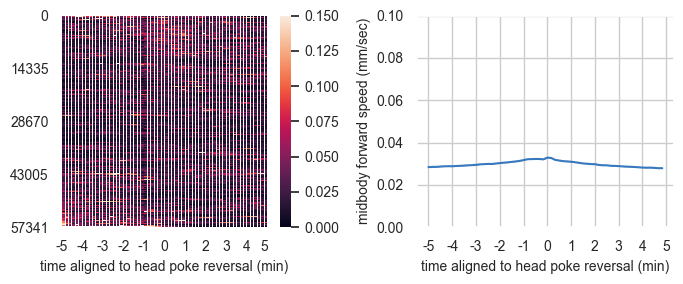

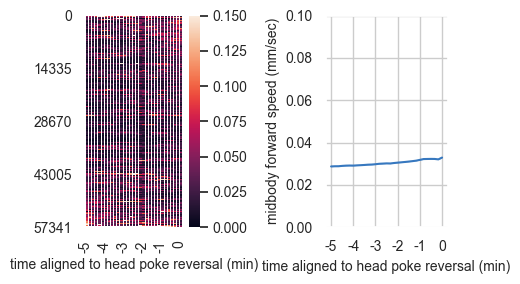

In [87]:
#Midbody Forward Speed Aligned to Head Poke Reversal:
binsPerMin = 6
numMins = 5
binTimeBefore = (numMins*binsPerMin) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = (numMins*binsPerMin) # X minutes after
binHPR = Data['bin_HeadPokeRev']
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],binLawnExit>0,binTimeBefore,binTimeAfter,dtype=float)

#Midbody Forward Speed, Midbody Reverse Speed, Midbody Angular Speed, 
#Fraction Forward, Fraction Reverse, Fraction Paused
#Head Angular Velocity, Head Radial Velocity, Quirkiness
#Headpoke + Fwd, Headpoke + Rev, Headpoke + Pause
# + throw in Bacterial Density and Lawn Boundary Distance

#make a subfolder to save these figures
separator = ','
genNames = separator.join(genotypes)
folderName = 'featuresAlignedtoHPREV_LLylim'
sub_subfolder = os.path.join(figpath,folderName)
if not os.path.exists(sub_subfolder):
    os.makedirs(sub_subfolder)

fig,axs = plt.subplots(1,2,figsize=(7,3))
axs, Data_aligned, Mask_aligned, binTimeLine, binAlignIdx = \
AlignAndPlot(axs, Data['bin_Midbody_fspeed_adj_inLawn'],binHPR,~Data['InLawnRunMask'],binTimeBefore,binTimeAfter,0,0.15,'midbody forward speed (mm/sec)', '',colors,"firstDeriv",False,0.7)
axs[1].set_ylim(0,0.1)
axs[0].set_xlabel('time aligned to head poke reversal (min)')
axs[1].set_xlabel('time aligned to head poke reversal (min)')

if saveFigures:
    outpath = os.path.join(sub_subfolder,'MidbodyFSpeed_HPRaligned_5minutesBeforeandAfter_'+datestring)
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(), bbox_inches='tight')
#     plt.savefig(outpath+'.pdf')

fig,axs = plt.subplots(1,2,figsize=(4.5,3))
axs, Data_aligned, Mask_aligned, binTimeLine, binAlignIdx = \
AlignAndPlot(axs, Data['bin_Midbody_fspeed_adj_inLawn'],binHPR,~Data['InLawnRunMask'],binTimeBefore,1,0,0.15,'midbody forward speed (mm/sec)', '',colors,"firstDeriv",False,0.7)
axs[1].set_ylim(0,0.1)
axs[0].set_xlabel('time aligned to head poke reversal (min)')
axs[1].set_xlabel('time aligned to head poke reversal (min)')

if saveFigures:
    outpath = os.path.join(sub_subfolder,'MidbodyFSpeed_HPRaligned_5minutesBefore_'+datestring)
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(), bbox_inches='tight')
#     plt.savefig(outpath+'.pdf')


## Behavioral States: Roaming and Dwelling

In [88]:
#Make a dataframe for plotting values of each input dimension by state for each animal

#switch fspeed to adj
ALLDATA_unscaled = np.hstack((Data['InLawnRunMask'].reshape(-1, 1),\
                              Data['RD_states_Matrix_exog_Cent'].reshape(-1, 1),\
                              Data['arHMM_MLstates'].reshape(-1, 1),\
                              Data['bin_Midbody_fspeed_adj'].reshape(-1, 1),\
                              -1*Data['bin_Midbody_rspeed'].reshape(-1, 1),\
                              Data['bin_Midbody_angspeed'].reshape(-1, 1),\
                              Data['bin_MovingForward'].reshape(-1, 1),\
                              Data['bin_MovingReverse'].reshape(-1, 1),\
                              Data['bin_Pause'].reshape(-1, 1),\
                              Data['bin_headAngVel_relMid'].reshape(-1, 1),\
                              Data['bin_headRadVel_relMid'].reshape(-1, 1),\
                              Data['bin_Quirkiness'].reshape(-1, 1),\
                              Data['bin_LawnExit_mostRecent'].reshape(-1,1),\
                              (30*Data['bin_HeadPokesAll']>=1).reshape(-1,1),\
                              (30*Data['bin_HeadPokeFwd']>=1).reshape(-1,1),\
                              (30*Data['bin_HeadPokeRev']>=1).reshape(-1,1),\
                              (30*Data['bin_HeadPokePause']>=1).reshape(-1,1),\
                              Data['bin_Lawn_Boundary_Dist'].reshape(-1,1),\
                              Data['bin_Bacterial_Density'].reshape(-1,1)))

bigDF = pd.DataFrame(data = ALLDATA_unscaled, columns = ['InLawnRunMask',\
                                                         'Roam/Dwell states',\
                                                         'AR-HMM states',\
                                                         'midbody forward speed',\
                                                         'midbody reverse speed',\
                                                         'midbody angular speed',\
                                                         'frac. forward',\
                                                         'frac. reverse',\
                                                         'frac. pause',\
                                                         'head angular velocity',\
                                                         'head radial velocity',\
                                                         'quirkiness',\
                                                         'lawn exit',\
                                                         'head pokes (all)',\
                                                         'head poke + fwd',\
                                                         'head poke + rev',\
                                                         'head poke + pause',\
                                                         'lawn boundary dist.',\
                                                         'bacterial density']).dropna()

# bigDF['Roam/Dwell states'] = pd.to_numeric(bigDF['Roam/Dwell states'],downcast='integer')
bigDF['Roam/Dwell states'] = bigDF['Roam/Dwell states'].astype("category").cat.rename_categories(['dwell','roam'])
bigDF['AR-HMM states'] = pd.to_numeric(bigDF['AR-HMM states'],downcast='integer')
bigDF['InLawnRunMask'] = bigDF['InLawnRunMask'].replace({1.0:True, 0.0:False})


In [89]:
#Make comparison DataFrame
from datetime import date, datetime, timedelta

keysToExtract = ['missingdata',\
                 'Centroid_x', 'Centroid_y', 'Centroid_speed', 'Centroid_angspeed',\
                 'CentroidDistToDenseSeam', 'HeadDistToDenseSeam', 'MidbodyCentDistToDenseSeam', \
                 'CentroidInSparse', 'CentroidInDense', 'CentroidOutside',\
                 'TrajAngleToDenseSeam', 'CentroidRegion', 'HeadRegion', 'MidbodyCentRegion', 'TailRegion', \
                 'Midbody_speed','Midbody_angspeed','Lawn_Boundary_Dist','Centroid_grayscale','Head_grayscale','Head_norm_grayscale','Bacterial_Density','Centroid_Bacterial_Density',\
                 'HeadPokeAngle', 'HeadPokeDist', 'HeadPokeFwd', 'HeadPokeIntervals', 'HeadPokePause', 'HeadPokeRev', 'HeadPokeSpeed', 'HeadPokesAll',
                 'Quirkiness','bin_Quirkiness_inLawn',
                 'Lawn_Exit','Lawn_Entry','bin_Head_speed','bin_Midbody_absSpeed','bin_Midbody_fspeed',\
                 'bin_Midbody_rspeed','bin_Midbody_angspeed','bin_Bacterial_Density','bin_Centroid_Bacterial_Density',\
                 'bin_MovingForward','bin_MovingReverse','bin_Pause',\
                 'bin_Radial_Dist','bin_Lawn_Boundary_Dist','bin_In_Or_Out','bin_LawnEntry','bin_LawnExit',\
                 'bin_HeadPokeFwd','bin_HeadPokeRev','bin_HeadPokePause','bin_HeadPokesAll',\
                 'bin_HeadPokeSpeed','bin_HeadPokeAngle','bin_HeadPokeDist',\
                 'bin_Centroid_speed_inLawn','bin_Centroid_angspeed_inLawn','bin_CentroidDistToDenseSeam_inLawn',\
                 'bin_HeadDistToDenseSeam_inLawn','bin_MidbodyCentDistToDenseSeam_inLawn','bin_TrajAngleToDenseSeam_inLawn',\
                 'bin_CentroidInSparse','bin_CentroidInDense','bin_CentroidOutside','bin_HeadInSparse',\
                 'bin_HeadInDense','bin_HeadOutside','bin_MidbodyCentInSparse','bin_MidbodyCentInDense','bin_MidbodyCentOutside',\
                 'binMissing_spline','binMissing_centroid','InLawnRunMask','InLawnRunMask_centroid',\
                 'bin_LawnExit_mostRecent','bin_Head_speed_inLawn','bin_Midbody_absSpeed_inLawn','bin_Midbody_fspeed_inLawn','bin_Midbody_rspeed_inLawn',\
                 'bin_Bacterial_Density_inLawn','bin_Centroid_Bacterial_Density_inLawn','bin_Head_norm_grayscale_inLawn','bin_MovingForward_inLawn','bin_MovingReverse_inLawn','bin_Pause_inLawn',\
                 'bin_Lawn_Boundary_Dist_inLawn','bin_Head_angspeed_inLawn','bin_Midbody_angspeed_inLawn',\
                 'RD_states_Matrix_exog','RD_states_Matrix_exog_Cent','arHMM_MLstates']


Datas = [wildtype['PD1074_od2_Data']]

genotypes = ['wild type']

forbiddenDates = []
datesToInclude = []
Data_subs, Data_comparison_dfs = compareGenotypes(Datas,genotypes,keysToExtract,binSize, 4, 2, forbiddenDates, datesToInclude)
Data_df = generateComparisonsDF(Data_comparison_dfs)

#set parameters for aligning things
framesPerMin = 6
numMins = 5
binTimeBefore = numMins*framesPerMin
binTimeAfter = binTimeBefore

genotype_colors = default_colors


In [90]:
saveFigures = False

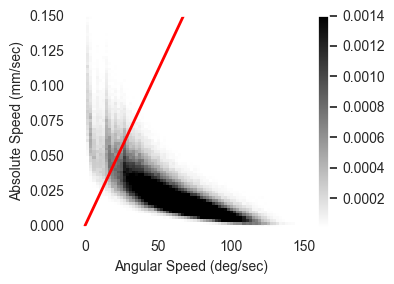

In [91]:
# 2D Histograms of Roaming/Dwelling
dataFrac = 1
numToChoose = np.round(Data['bin_Centroid_angspeed_inLawn'].size*dataFrac).astype(int)
randIdx = npr.choice(np.arange(Data['bin_Centroid_angspeed_inLawn'].size),numToChoose,replace=False)
# randIdx = npr.choice(np.arange(Data['bin_Centroid_angspeed_inLawn'].size),int(Data['bin_Centroid_angspeed_inLawn'].size),replace=False)

fig,axs = plt.subplots(1,1,figsize=(4,3))
decision_slope = 450
x_offset = 0
numBins = 75

norm = mpl.colors.Normalize(vmin=1e-5,vmax=1.4e-3)
# norm = mpl.colors.LogNorm(vmin=1e-4,vmax=1e-2,clip=True)
# norm = mpl.colors.SymLogNorm(linthresh=1e-7, linscale=1, vmin=1e-5, vmax=5e-3)

plot2dhistosPC1vPC2(axs,
                  norm,
                  '',
                  Data['bin_Centroid_angspeed_inLawn'].ravel()[randIdx],
                  'Angular Speed (deg/sec)',
                  np.linspace(-5,150,numBins),
                  Data['bin_Centroid_speed_inLawn'].ravel()[randIdx],
                  'Absolute Speed (mm/sec)',
                  np.linspace(-0.001,0.15,numBins),
                  plt.get_cmap('binary'))

axs.plot(np.linspace(0,150,numBins),(np.linspace(0,150,numBins)-x_offset)/decision_slope,color='red',lw=2)
# axs.set_title(genotypes,fontstyle='italic')

if saveFigures:
    outpath = os.path.join(figpath,'RoamingDwellingDecisionBoundary_Centroid'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')

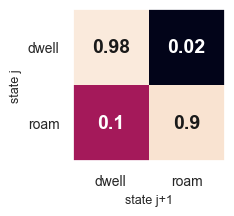

In [92]:
#plot transition matrix (pre-trained)
fig,axs = plt.subplots(1,1,figsize=(2.5,2.5))
tmat = RD_hmm_Cent_exog.transitions.transition_matrix
ChosenModel = RD_hmm_Cent_exog

norm = mpl.colors.LogNorm(vmin=tmat.min(), vmax=tmat.max())
im = axs.imshow(tmat,norm=norm)#,cmap='viridis')
for i in range(tmat.shape[0]):
    for j in range(tmat.shape[1]):
        if (i==0 and j==1) or (i==1 and j==0):
            text = axs.text(j, i, np.round(tmat[i, j],2), \
                ha="center", va="center", color="w",fontweight='bold',fontsize=14)
        else:
            text = axs.text(j, i, np.round(tmat[i, j],2), \
                            ha="center", va="center", color="k",fontweight='bold',fontsize=14)
axs.set_xticks(np.arange(0,ChosenModel.K))
axs.set_xticklabels(['dwell','roam'])
axs.set_yticks(np.arange(0,ChosenModel.K))
axs.set_yticklabels(['dwell','roam'])
axs.set_xlabel('state j+1',fontsize=9)
axs.set_ylabel('state j',fontsize=9)
axs.grid(b=None)
# axs.set_title('Transition Matrix')


if saveFigures:
    outpath = os.path.join(figpath,'RoamingDwelling'+'_numstates_'+str(ChosenModel.K)+'_TransitionMatrix_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)


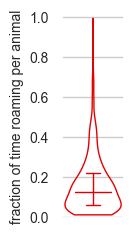

In [93]:
#plot overall frac. roam
roam_df = pd.DataFrame(Data['RD_states_Matrix_exog_Cent'].astype(float))
roam_df['frac dwell'] = roam_df.apply(lambda x: (np.nansum(x==0.0)+1)/(np.sum(~np.isnan(x))+1),axis=1)
roam_df['frac roam'] = roam_df.apply(lambda x: (np.nansum(x==1.0)+1)/(np.sum(~np.isnan(x))+1),axis=1)

fig,axs = plt.subplots(1,1,figsize=(1.5,2.5))
subsample_data = roam_df.sample(n=100,random_state=0, replace=False)

# #####################
#then overlay a violinplot, outline only
g = sns.violinplot(ax = axs, y='frac roam',showfliers=False, color=colors[1], data=roam_df, dodge=True, linewidth=1,saturation = 1,inner=None,cut=0,scale='width',zorder=0)
for violin in g.collections:
    violin.set_edgecolor(violin.get_facecolor())
    violin.set_facecolor('None')

#DIY custom boxplot
#make the medians pop, plot the quartiles a bit narrower
m_width = 0.5
q_width = 0.2
medians = roam_df['frac roam'].median()
lower_q = roam_df['frac roam'].quantile(0.25)
upper_q = roam_df['frac roam'].quantile(0.75)

for i, xtick in enumerate(g.get_xticks()):
    g.plot([xtick-q_width/2, xtick+q_width/2], [lower_q, lower_q], color= colors[1], linestyle='-', linewidth=1,zorder=3)
    g.plot([xtick-q_width/2, xtick+q_width/2], [upper_q, upper_q], color= colors[1], linestyle='-', linewidth=1,zorder=3)
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians, medians], color= colors[1], linestyle='-', linewidth=1,zorder=3)
    g.plot([xtick, xtick], [lower_q, upper_q], color= colors[1], linestyle='-', linewidth=1,zorder=3)
    
# #####################

g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_ylim([-0.01,1.01])
g.set_ylabel('fraction of time roaming per animal')
g.legend([],[], frameon=False)

if saveFigures:
    outpath = os.path.join(figpath,'FracRoam_Cent'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)


In [94]:
roam_df['frac roam'].median()

0.12396694214876033

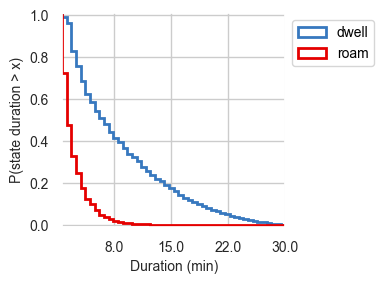

In [95]:
# plot R/D state durations 
# plot as exceedance curves (ccdf -- how often is the duration greater than x?)


infDurations_RD_ALL = computeStateDurations(Data['RD_states_Matrix_exog_Cent'].astype(int).filled(25))

fig,axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(4,3))

RDlabels = ['dwell','roam']

durBins = np.linspace(0,30*6,50)
ticklabels=np.round((10/60*np.linspace(0,durBins[-1],5))).astype(str)

[axs.hist(infDurations_RD_ALL[s],bins=durBins,color=colors[s],density=True,linestyle='solid',alpha=1,histtype='step',cumulative=-1,lw=2,label=RDlabels[s]) for s in range(0,2)]

axs.set_xticks(ticks=np.linspace(0,durBins[-1],5))
axs.set_xticklabels(ticklabels)
axs.set_xlim([durBins[1],durBins[-1]])
axs.set_ylim([-0.01,1.01])
axs.set_xlabel('Duration (min)')
axs.set_ylabel('P(state duration > x)')
axs.legend(bbox_to_anchor=(1, 1),loc="upper left")
axs.set_ylabel('P(state duration > x)')


if saveFigures:
    outpath = os.path.join(figpath,'RoamDwell_Cent_StateDurations_byState'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

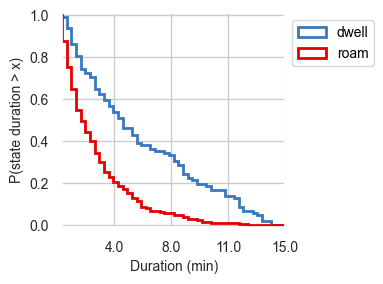

In [96]:
# plot survival curve of R/D --> leaving
roamDur = computeStateDurationsBeforeEvent(Data['RD_states_Matrix_exog_Cent'],True,Data['bin_LawnExit_mostRecent'])
dwellDur = computeStateDurationsBeforeEvent(Data['RD_states_Matrix_exog_Cent'],False,Data['bin_LawnExit_mostRecent'])

infDurations_arHMMstates_ALL = [dwellDur,roamDur]

fig,axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(4,3))

statelabels = ['dwell','roam']

durBins = np.linspace(0,15*6,50)
ticklabels=np.round((10/60*np.linspace(0,durBins[-1],5))).astype(str)

[axs.hist(infDurations_arHMMstates_ALL[s],bins=durBins,color=colors[s],density=True,linestyle='solid',alpha=1,histtype='step',cumulative=-1,lw=2,label=statelabels[s]) for s in range(0,2)]

axs.set_xticks(ticks=np.linspace(0,durBins[-1],5))
axs.set_xticklabels(ticklabels)
axs.set_xlim([durBins[1],durBins[-1]])
axs.set_ylim([-0.01,1.01])
axs.set_xlabel('Duration (min)')
axs.set_ylabel('P(state duration > x)')
axs.legend(bbox_to_anchor=(1, 1),loc="upper left")
axs.set_ylabel('P(state duration > x)')

if saveFigures:
    outpath = os.path.join(figpath,'RoamDwell_Cent_SurvivalToLeavingDuration_byState'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

3.5624011237048574e-05, ****


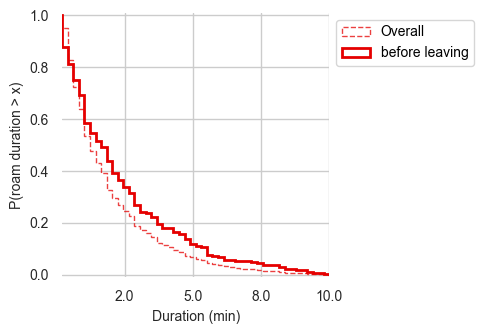

In [97]:
#Compare Roaming durations overall and before Leaving
from scipy.stats import ks_2samp
fig,axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(5,3.5))

durBins = np.linspace(0,10*6,50)
ticklabels=np.round((10/60*np.linspace(0,durBins[-1],5))).astype(str)

infDurations_RD_ALL = computeStateDurations(Data['RD_states_Matrix_exog_Cent'].astype(int).filled(25))
axs.hist(infDurations_RD_ALL[1],bins=durBins,color=colors[1],density=True,linestyle='dashed',alpha=0.75,histtype='step',cumulative=-1,lw=1,label='Overall')
roamDurbL = computeStateDurationsBeforeEvent(Data['RD_states_Matrix_exog_Cent'],True,Data['bin_LawnExit_mostRecent'])
axs.hist(roamDurbL,bins=durBins,color=colors[1],density=True,linestyle='solid',alpha=1,histtype='step',cumulative=-1,lw=2,label='before leaving')
    
plt.box(False)
axs.set_xticks(ticks=np.linspace(0,durBins[-1],5))
axs.set_xticklabels(ticklabels)
axs.set_xlim([durBins[1],durBins[-1]])
axs.set_ylim([-0.01,1.01])
# axs.set_yscale("log", basey=10)
axs.set_xlabel('Duration (min)')
axs.set_ylabel('P(roam duration > x)')
axs.legend(bbox_to_anchor=(1, 1),loc="upper left")
if saveFigures:
    outpath = os.path.join(figpath,'Roam_Durations'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

#Perform a Kolmogorov-Smirnov 2sample test 
_,pval = ks_2samp(infDurations_RD_ALL[1], roamDurbL, alternative='two-sided')
print(str(pval)+', '+categorizePValue(pval))    


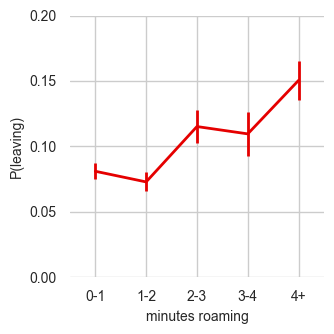

In [98]:
#probability of leaving given roaming/dwelling for X amount of time
#for a given bin of time durations:
#     fraction of roaming intervals resulting in leaving / total roaming event 

infDurations_RD_ALL = computeStateDurations(Data['RD_states_Matrix_exog_Cent'].astype(int).filled(25))
dwellOverallDur = infDurations_RD_ALL[0]
roamOverallDur = infDurations_RD_ALL[1]

dwellBeforeLeaveDur = computeStateDurationsBeforeEvent(Data['RD_states_Matrix_exog_Cent'],False,Data['bin_LawnExit_mostRecent'])
roamBeforeLeaveDur = computeStateDurationsBeforeEvent(Data['RD_states_Matrix_exog_Cent'],True,Data['bin_LawnExit_mostRecent'])

maxDuration = 5 #minutes
binsize = 1 #minutes
minuteBins = np.concatenate((np.arange(0,maxDuration*6,binsize*6),[240]))
binsToPlot = np.concatenate((minuteBins[:-1],[minuteBins[-2]+binsize*6]))
statelabels = ['dwell','roam']

dwellfracLeavingPerBin,dwell_ste_prop,dwell_OverallCounts,_ = getProbLeavingvsTimeinState(dwellBeforeLeaveDur,dwellOverallDur,minuteBins)
roamfracLeavingPerBin,roam_ste_prop,roam_OverallCounts,_ = getProbLeavingvsTimeinState(roamBeforeLeaveDur,roamOverallDur,minuteBins)

fig,axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(3.5,3.5))
# mask = dwell_OverallCounts<5
# dwellfracLeavingPerBin[mask]=np.nan
# dwell_ste_prop[mask]=np.nan
# axs.errorbar(binsToPlot[1:]/6,dwellfracLeavingPerBin, yerr=dwell_ste_prop,color=colors[0],label='dwell',lw=2)

mask = roam_OverallCounts<5
roamfracLeavingPerBin[mask]=np.nan
roam_ste_prop[mask]=np.nan
axs.errorbar(binsToPlot[1:]/6,roamfracLeavingPerBin, yerr=roam_ste_prop,color=colors[1],label='roam',lw=2)

plt.box(False)
axs.set_xticks(np.arange(0,maxDuration+1,binsize))
axs.set_yticks(np.arange(0,0.25,0.05))
binlabels = ['_','0-1','1-2','2-3','3-4','4+']
axs.set_xticklabels(binlabels)
axs.set_xlim([binsize-0.5,maxDuration+0.5])
axs.set_ylim([0,0.2])
axs.set_xlabel('minutes roaming')
axs.set_ylabel('P(leaving)')
# axs.legend(bbox_to_anchor=(1, 1),loc="upper left",frameon=False)

if saveFigures:
    outpath = os.path.join(figpath,'RoamDwell_Cent_pLeavingvsStateDuration'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

In [99]:
#make folders for aligning to leaving or head poke reversals
RDhmm = RD_hmm_Cent_exog
RDstates = Data['RD_states_Matrix_exog_Cent']

folderName = 'featuresAlignedtoLawnLeaving'
sub_subfolder = os.path.join(figpath,folderName)
if not os.path.exists(sub_subfolder):
    os.makedirs(sub_subfolder)
    
folderName = 'featuresAlignedtoHPREV_LLylim'
sub_subfolder = os.path.join(figpath,folderName)
if not os.path.exists(sub_subfolder):
    os.makedirs(sub_subfolder)

In [100]:
saveFigures = True

/Users/eliasscheer/PycharmProjects/lawnleaving/commonFunctions.py:1270: RuntimeWarning: invalid value encountered in true_divide
  probStateAligned = np.array([(numer[k] / denom[k]) for k in range(0, len(timeLine))]).reshape(len(timeLine), num_states).T
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/statsmodels/stats/proportion.py:256: RuntimeWarning: invalid value encountered in true_divide
  proportions = counts / n
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/eliasscheer/PycharmProjects/lawnleaving/commonFunctions.py:1270: RuntimeWarning: invalid value encountered in true_divide
  probStateAligned = np.array([(numer[k] / denom[k]) for k in range(0, len(timeLine))]).reshape(len(timeLine), num_states).T
/Users/eliasscheer/Pychar

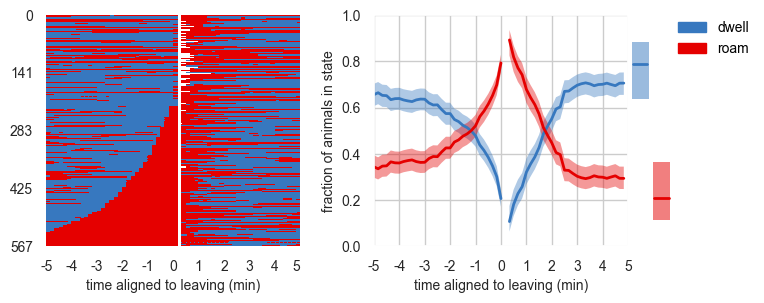

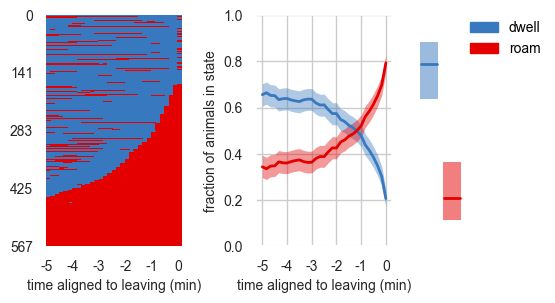

In [101]:
#show R/D state alignments to lawn leaving and headpoke+rev
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import gridspec

binsPerMin = 6
figsize = (9,3)

#align data to HPREV and LL
binHeadPokeRev = Data['bin_HeadPokeRev']
binLawnExit = Data['bin_LawnExit_mostRecent']
# binLawnExit = findMostRecentInLawnforLL(binLawnExit>0,3,~Data['InLawnRunMask'])
numMins = 5
binTimeBefore = (numMins*6) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = (numMins*6) # X minutes after
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],binLawnExit>0,binTimeBefore,binTimeAfter,dtype=float)
xticksToPlot = np.hstack((binTimeLine[0:-1:binsPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*binsPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / binsPerMin).astype(int)

f, ax = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios': [3,3,0.5],'hspace':0,'wspace':0.4})
ax, _ = plotMLstates_Aligned_masked(ax,Data['RD_states_Matrix_exog_Cent'],RD_hmm_Cent_exog,~Data['InLawnRunMask'],binLawnExit,binTimeLine,binTimeBefore,binTimeAfter,binsPerMin,'',colors,numLastBins,False,figsize=figsize)

ax[0], StateByAligned_sorted = plotMLstateHeatmap_durSort(ax[0], 
                                      Data['RD_states_Matrix_exog_Cent'],
                                      True,
                                      ~Data['InLawnRunMask'], 
                                      Data['bin_LawnExit_mostRecent'], 
                                      binsPerMin, 
                                      binTimeBefore, 
                                      binTimeAfter, 
                                      RD_hmm_Cent_exog,
                                      colors)

ax[0].set_xticks(xticksToPlot + binTimeBefore)
ax[0].set_xticklabels(xtickLabels,rotation=0)
ax[1].set_xticks(xtickLabels)
ax[1].set_xticklabels(xtickLabels)
ax[1].set_xlim(-numMins,numMins)
ax[1].set_ylim(0,1)
ax[0].set_xlabel('time aligned to leaving (min)')
ax[1].set_xlabel('time aligned to leaving (min)')


#get all R/D values so we can generate boxplots with confidence intervals
RD_overall = Data['RD_states_Matrix_exog_Cent']
fracDwell_leavers = np.nanmean(~RD_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]],axis=1)
fracRoam_leavers = np.nanmean(RD_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]],axis=1)
fracDwellRoam = [fracDwell_leavers,fracRoam_leavers]
fracDwellRoam_stacked = pd.DataFrame(data=stack_padding(fracDwellRoam).T,columns=['dwell','roam'])


###########
#plot accompanying boxplots #change this to have the same look as the plots with SEM
g = sns.boxplot(data=fracDwellRoam_stacked,
            showfliers=False,
            whis=0,
            palette = colors,
            saturation = 1,
            ax = ax[2])

# DIY custom boxplot
for i,box in enumerate(g.artists):
    box.set_edgecolor(mpl.colors.to_rgba(colors[i], 0))
    box.set_facecolor(mpl.colors.to_rgba(colors[i], 0.50))
    # iterate over whiskers and median lines
    for j in g.lines:
         j.set_color(mpl.colors.to_rgba(colors[i], 0))

#make the medians pop
m_width = 0.7
medians = fracDwellRoam_stacked.melt().groupby("variable").median().reindex(['dwell','roam'])
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= colors[i], linestyle='-', linewidth=2,zorder=3)

ax[2].set_frame_on(False)
ax[2].set_xticks([])
ax[2].set_ylim(0,1)
ax[2].set_yticks([]) 
##################
    
#move axes around
box = ax[2].get_position()
ax[2].set_position([box.x0-0.08, box.y0, box.width, box.height])
ax[2].set_frame_on(False)
ax[2].set_xticks([])
# create color map with colors and df.names
cmap = dict(zip(fracDwellRoam_stacked.columns, colors))
# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
# add the legend
ax[2].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

# create color map with colors and df.names
cmap = dict(zip(fracDwellRoam_stacked.columns, colors))
# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
# add the legend
ax[2].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

#SAVE IT
folderName = 'featuresAlignedtoLawnLeaving'
sub_subfolder = os.path.join(figpath,folderName)
if saveFigures:
    outpath = os.path.join(sub_subfolder,'RoamingDwellingStatesAlignedToLeaving_'+str(numMins)+'minBeforeAndAfter'+'_'+datestring)
    plt.savefig(outpath+'.pdf',bbox_extra_artists=(), bbox_inches='tight')
    plt.savefig(outpath+'.png',dpi=300, bbox_extra_artists=(), bbox_inches='tight')
    
########################################################################    
#now just 5 minutes before

numMins = 5
binTimeBefore = (numMins*6) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = 1 # X minutes after
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],binLawnExit>0,binTimeBefore,binTimeAfter,dtype=float)
xticksToPlot = np.hstack((binTimeLine[0:-1:binsPerMin], binTimeLine[-1]))
xtickLabels = np.ceil(xticksToPlot / binsPerMin).astype(int)

f, ax = plt.subplots(1, 3, figsize=(6,3), gridspec_kw={'width_ratios': [3,3,1],'hspace':0,'wspace':0.7})
ax, _ = plotMLstates_Aligned_masked(ax,
                                 Data['RD_states_Matrix_exog_Cent'],
                                 RD_hmm_Cent_exog,
                                 ~Data['InLawnRunMask'],
                                 binLawnExit,
                                 binTimeLine,
                                 binTimeBefore,
                                 binTimeAfter,
                                 binsPerMin,
                                 '',
                                 colors,
                                 numLastBins,
                                 False,
                                 figsize=(6,4))

ax[0], StateByAligned_sorted = plotMLstateHeatmap_durSort(ax[0], 
                                      Data['RD_states_Matrix_exog_Cent'],
                                      True,
                                      ~Data['InLawnRunMask'], 
                                      Data['bin_LawnExit_mostRecent'], 
                                      binsPerMin, 
                                      binTimeBefore, 
                                      binTimeAfter, 
                                      RD_hmm_Cent_exog,
                                      colors)

ax[0].set_xticks(xticksToPlot + binTimeBefore)
ax[0].set_xticklabels(xtickLabels,rotation=0)
ax[1].set_xticks(xtickLabels)
ax[1].set_xticklabels(xtickLabels)
ax[1].set_ylim(0,1)
ax[0].set_xlabel('time aligned to leaving (min)')
ax[1].set_xlabel('time aligned to leaving (min)')

###########
#plot accompanying boxplots #change this to have the same look as the plots with SEM
g = sns.boxplot(data=fracDwellRoam_stacked,
            showfliers=False,
            whis=0,
            palette = colors,
            saturation = 1,
            ax = ax[2])

# DIY custom boxplot
for i,box in enumerate(g.artists):
    box.set_edgecolor(mpl.colors.to_rgba(colors[i], 0))
    box.set_facecolor(mpl.colors.to_rgba(colors[i], 0.50))
    # iterate over whiskers and median lines
    for j in g.lines:
         j.set_color(mpl.colors.to_rgba(colors[i], 0))

#make the medians pop
m_width = 0.7
medians = fracDwellRoam_stacked.melt().groupby("variable").median().reindex(['dwell','roam'])
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= colors[i], linestyle='-', linewidth=2,zorder=3)

ax[2].set_frame_on(False)
ax[2].set_xticks([])
ax[2].set_ylim(0,1)
ax[2].set_yticks([]) 
    
#move axes around
box = ax[2].get_position()
ax[2].set_position([box.x0-0.08, box.y0, box.width, box.height])
ax[2].set_frame_on(False)
ax[2].set_xticks([])
# create color map with colors and df.names
cmap = dict(zip(fracDwellRoam_stacked.columns, colors))
# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
# add the legend
ax[2].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

# create color map with colors and df.names
cmap = dict(zip(fracDwellRoam_stacked.columns, colors))
# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
# add the legend
ax[2].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)

#SAVE IT
folderName = 'featuresAlignedtoLawnLeaving'
sub_subfolder = os.path.join(figpath,folderName)
if saveFigures:
    outpath = os.path.join(sub_subfolder,'RoamingDwellingStatesAlignedToLeaving_'+str(numMins)+'minBefore'+'_'+datestring)
    plt.savefig(outpath+'.pdf',bbox_extra_artists=(), bbox_inches='tight')
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(), bbox_inches='tight')
    


In [102]:
#fraction of time roaming only among leavers
leaverIdx = np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]
fracDwell_leavers = pd.DataFrame(np.mean(~Data['RD_states_Matrix_exog_Cent'][leaverIdx,:],axis=1))
fracRoam_leavers = pd.DataFrame(np.mean(Data['RD_states_Matrix_exog_Cent'][leaverIdx,:],axis=1))


/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
<ipython-input-103-0b7ddc75f1bb>:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outpath,dpi=300,bbox_extra_artists=(), bbox_inches='tight')#too many entries to plot in vector graphics
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


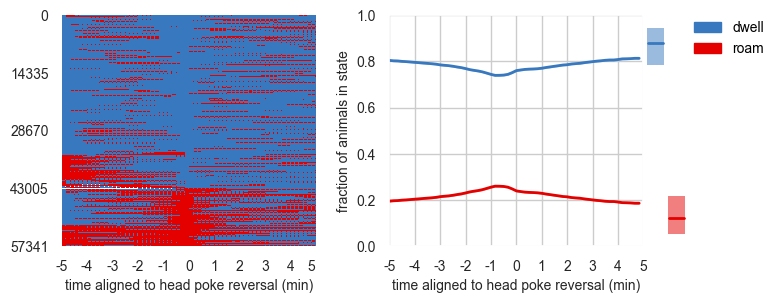

In [103]:
#Plot R/D alignments to head poke reversal
###############

#align data to HPREV and LL
binHeadPokeRev = Data['bin_HeadPokeRev']
binLawnExit = Data['bin_LawnExit_mostRecent']
# binLawnExit = findMostRecentInLawnforLL(binLawnExit>0,3,~Data['InLawnRunMask'])
numMins = 5
binTimeBefore = (numMins*6) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = (numMins*6) # X minutes after
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],binLawnExit>0,binTimeBefore,binTimeAfter,dtype=float)
xticksToPlot = np.hstack((binTimeLine[0:-1:binsPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*binsPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / binsPerMin).astype(int)


figsize=(9,3)

f, ax = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios': [3,3,0.5],'hspace':0,'wspace':0.4})
ax, _ = plotMLstates_Aligned_masked(ax,Data['RD_states_Matrix_exog_Cent'],RD_hmm_Cent_exog,~Data['InLawnRunMask'],binHeadPokeRev>0,binTimeLine,binTimeBefore,binTimeAfter,binsPerMin,'',colors,numLastBins,False,figsize=figsize)

ax[0].set_xticks(xticksToPlot + binTimeBefore)
ax[0].set_xticklabels(xtickLabels,rotation=0)
ax[1].set_xticks(xtickLabels)
ax[1].set_xticklabels(xtickLabels)
ax[1].set_xlim(-numMins,numMins)
ax[1].set_ylim(0,1)
ax[0].set_xlabel('time aligned to head poke reversal (min)')
# ax[1].set_ylabel('fraction of animals in state')
ax[1].set_xlabel('time aligned to head poke reversal (min)')

#get all R/D values so we can generate boxplots with confidence intervals
RD_overall = Data['RD_states_Matrix_exog_Cent']
fracDwell_leavers = np.nanmean(~RD_overall[np.where(np.sum(Data['bin_HeadPokeRev']>0,axis=1)>0)[0]],axis=1)
fracRoam_leavers = np.nanmean(RD_overall[np.where(np.sum(Data['bin_HeadPokeRev']>0,axis=1)>0)[0]],axis=1)
fracDwellRoam = [fracDwell_leavers,fracRoam_leavers]
fracDwellRoam_stacked = pd.DataFrame(data=stack_padding(fracDwellRoam).T,columns=['dwell','roam'])

###########
#plot accompanying boxplots #change this to have the same look as the plots with SEM
g = sns.boxplot(data=fracDwellRoam_stacked,
            showfliers=False,
            whis=0,
            palette = colors,
            saturation = 1,
            ax = ax[2])

# DIY custom boxplot
for i,box in enumerate(g.artists):
    box.set_edgecolor(mpl.colors.to_rgba(colors[i], 0))
    box.set_facecolor(mpl.colors.to_rgba(colors[i], 0.50))
    # iterate over whiskers and median lines
    for j in g.lines:
         j.set_color(mpl.colors.to_rgba(colors[i], 0))

#make the medians pop
m_width = 0.7
medians = fracDwellRoam_stacked.melt().groupby("variable").median().reindex(['dwell','roam'])
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= colors[i], linestyle='-', linewidth=2,zorder=3)

ax[2].set_frame_on(False)
ax[2].set_xticks([])
ax[2].set_ylim(0,1)
ax[2].set_yticks([]) 
##################

#move axes around
box = ax[2].get_position()
ax[2].set_position([box.x0-0.08, box.y0, box.width, box.height])
ax[2].set_frame_on(False)
ax[2].set_xticks([])
# create color map with colors and df.names
cmap = dict(zip(fracDwellRoam_stacked.columns, colors))
# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
# add the legend
ax[2].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)
    

folderName = 'featuresAlignedtoHPREV_LLylim'
sub_subfolder = os.path.join(figpath,folderName)
if saveFigures:
    outpath = os.path.join(sub_subfolder,'RoamingDwellingStatesAlignedToHPREV_'+str(numMins)+'minBeforeAndAfter'+'_'+datestring+'.png')
    plt.savefig(outpath,dpi=300,bbox_extra_artists=(), bbox_inches='tight')#too many entries to plot in vector graphics

In [104]:
#roaming rate X minutes before and at the time of lawn leaving

RD_LE_Aligned, Mask_LE_Aligned, prob_RD_LE_Aligned, timeLine, alignIdx, probStateAligned_prop_ci = \
        genProbStateAligned_masked(Data['RD_states_Matrix_exog_Cent'],
                                   ~Data['InLawnRunMask'], 
                                   binLawnExit, 
                                   binTimeBefore, 
                                   binTimeAfter, 
                                   RD_hmm_Cent_exog.K)

RD_mean = np.nanmean(RD_LE_Aligned,axis=0)
RD_before = RD_mean[0]
RD_LE = RD_mean[alignIdx]

print(RD_before,RD_LE)

0.34368530020703936 0.7936507936507936


/Users/eliasscheer/PycharmProjects/lawnleaving/commonFunctions.py:1270: RuntimeWarning: invalid value encountered in true_divide
  probStateAligned = np.array([(numer[k] / denom[k]) for k in range(0, len(timeLine))]).reshape(len(timeLine), num_states).T
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/statsmodels/stats/proportion.py:256: RuntimeWarning: invalid value encountered in true_divide
  proportions = counts / n


## Behavioral States: 4-state AR-HMM

In [105]:
color_names = ['vibrant purple','azure','turquoise','salmon']
arhmm_colors = sns.xkcd_palette(color_names)

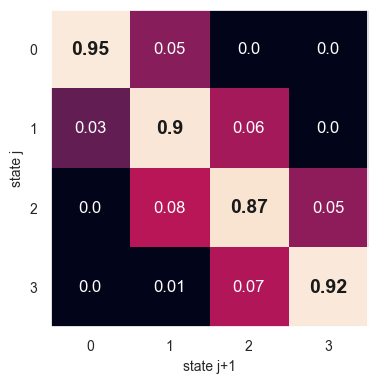

In [106]:
#plot transition matrix (5 features k = 4, kappa = 25000)
fig,axs = plt.subplots(1,1,figsize=(4,4))
ChosenModel = arHMM_model
tmat = ChosenModel.transitions.transition_matrix

norm = mpl.colors.LogNorm(vmin=0.01, vmax=tmat.max())
# norm = mpl.colors.Normalize(vmin=0.02,vmax=0.95)
im = axs.imshow(tmat,norm=norm)#,cmap='viridis')
for i in range(tmat.shape[0]):
    for j in range(tmat.shape[1]):
        if tmat[i][j] < 0.15:
            text = axs.text(j, i, np.round(tmat[i, j],2), \
                ha="center", va="center", color="w",fontweight='normal',fontsize=12)
        else:
            text = axs.text(j, i, np.round(tmat[i, j],2), \
                            ha="center", va="center", color="k",fontweight='bold',fontsize=14)
axs.set_xticks(np.arange(0,ChosenModel.K))
axs.set_yticks(np.arange(0,ChosenModel.K))
axs.grid(b=None)
# axs.set_title('Transition Matrix'+ ', k = '+str(ChosenModel.K)+', kappa = '+str(ChosenModel.transitions.kappa))
axs.set_xlabel('state j+1')
axs.set_ylabel('state j')

outpath = os.path.join(figpath,'TransitionMatrix'+'_ChosenModel'+'_kappa_'+str(ChosenModel.transitions.kappa)+'_numstates_'+str(ChosenModel.K)+'_'+datestring+'.pdf')
plt.savefig(outpath)#,dpi=300)


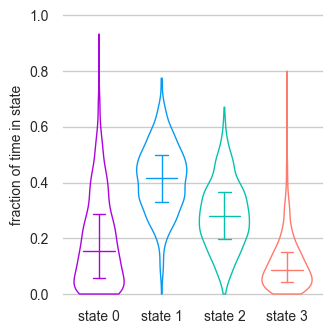

In [107]:
#fraction of time spent in state, change this to violin plot
MLstates = Data['arHMM_MLstates']
MLstates_df = pd.DataFrame(data=MLstates)
StateFracs = pd.DataFrame(data=np.vstack([MLstates_df.apply(lambda x: np.nansum(x==i)/np.sum(~np.isnan(x)),axis=1) for i in range(4)]).T,\
                          columns=['state 0','state 1','state 2','state 3'])
fig,axs = plt.subplots(1,1,figsize=(3.5,3.5))

# g = sns.violinplot(data=StateFracs,showfliers=False,palette=arhmm_colors, saturation = 1,inner=None,linewidth=0,cut=True,scale='width',ax=axs,zorder=1)
# sns.boxplot(data=StateFracs,showfliers=False,palette=arhmm_colors, saturation = 1,width=0.2,linewidth=1.5,boxprops={'zorder': 2})

# #####################
#then overlay a violinplot, outline only
g = sns.violinplot(ax = axs, data=StateFracs,showfliers=False, palette=arhmm_colors, dodge=True, linewidth=1,saturation = 1,inner=None,cut=0,scale='width',zorder=0)
for violin in g.collections:
    violin.set_edgecolor(violin.get_facecolor())
    violin.set_facecolor('None')

#DIY custom boxplot
#make the medians pop, plot the quartiles a bit narrower
m_width = 0.5
q_width = 0.2
medians = StateFracs.median()
lower_q = StateFracs.quantile(0.25)
upper_q = StateFracs.quantile(0.75)

for i, xtick in enumerate(g.get_xticks()):
    g.plot([xtick-q_width/2, xtick+q_width/2], [lower_q[i], lower_q[i]], color= arhmm_colors[i], linestyle='-', linewidth=1,zorder=3)
    g.plot([xtick-q_width/2, xtick+q_width/2], [upper_q[i], upper_q[i]], color= arhmm_colors[i], linestyle='-', linewidth=1,zorder=3)
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians[i], medians[i]], color= arhmm_colors[i], linestyle='-', linewidth=1,zorder=3)
    g.plot([xtick, xtick], [lower_q[i], upper_q[i]], color=arhmm_colors[i], linestyle='-', linewidth=1,zorder=3)
    
# #####################

g.set_ylim([-0.01,1.01])
g.set_xticklabels(g.get_xticklabels(), rotation=0)
g.set_ylabel('fraction of time in state')
g.legend([],[], frameon=False)


if saveFigures:
    outpath = os.path.join(figpath,'Frac_ARHMMstate_peranimal'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

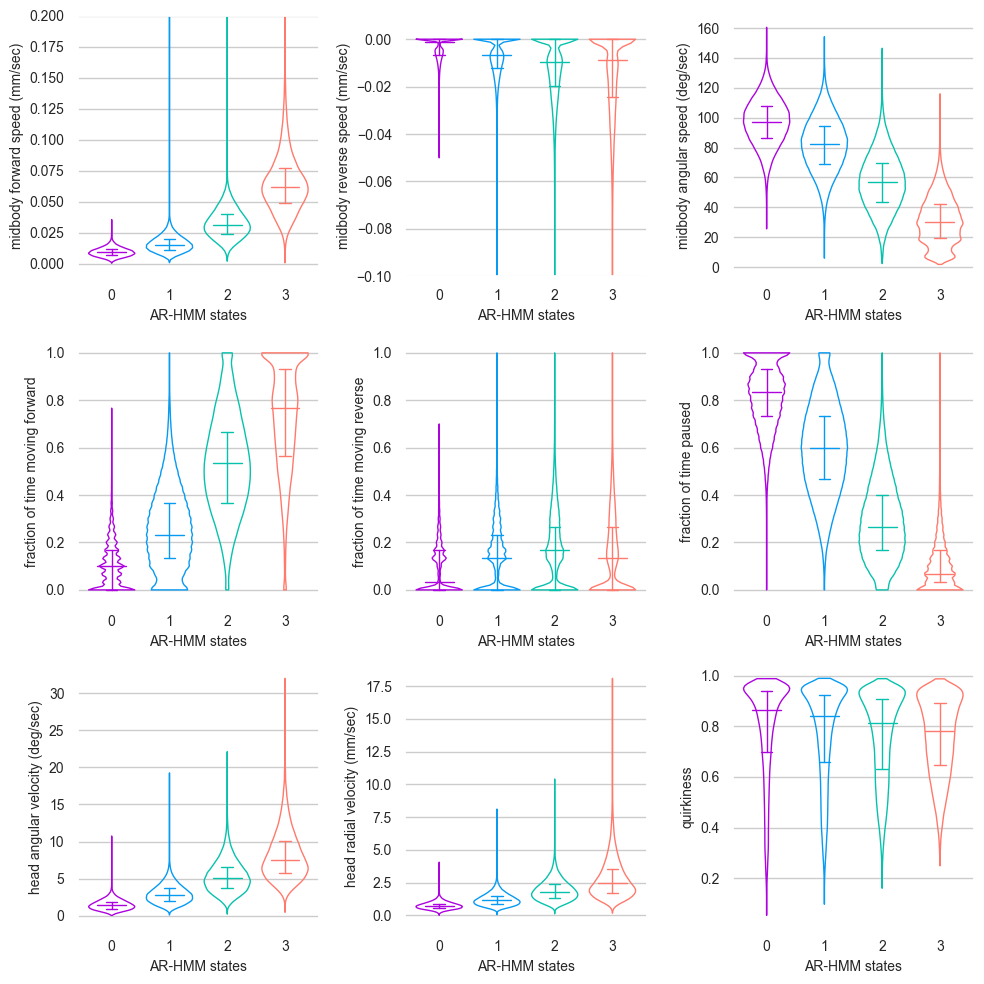

In [108]:
#Plot violin+box plots comparing the input dimensions in the AR-HMM states
fig,axs = plt.subplots(3,3,figsize=(10,10))
ax_flat = axs.ravel()

xvar = 'AR-HMM states'

yvar = 'midbody forward speed'
df = bigDF[[xvar,yvar]].reset_index(drop=True).pivot(columns=xvar,values=yvar)
customViolinBoxPlot(df,arhmm_colors,ax_flat[0])

yvar = 'midbody reverse speed'
df = bigDF[[xvar,yvar]].reset_index(drop=True).pivot(columns=xvar,values=yvar)
customViolinBoxPlot(df,arhmm_colors,ax_flat[1])

yvar = 'midbody angular speed'
df = bigDF[[xvar,yvar]].reset_index(drop=True).pivot(columns=xvar,values=yvar)
customViolinBoxPlot(df,arhmm_colors,ax_flat[2])

yvar = 'frac. forward'
df = bigDF[[xvar,yvar]].reset_index(drop=True).pivot(columns=xvar,values=yvar)
customViolinBoxPlot(df,arhmm_colors,ax_flat[3])

yvar = 'frac. reverse'
df = bigDF[[xvar,yvar]].reset_index(drop=True).pivot(columns=xvar,values=yvar)
customViolinBoxPlot(df,arhmm_colors,ax_flat[4])

yvar = 'frac. pause'
df = bigDF[[xvar,yvar]].reset_index(drop=True).pivot(columns=xvar,values=yvar)
customViolinBoxPlot(df,arhmm_colors,ax_flat[5])

yvar = 'head angular velocity'
df = bigDF[[xvar,yvar]].reset_index(drop=True).pivot(columns=xvar,values=yvar)
customViolinBoxPlot(df,arhmm_colors,ax_flat[6])

yvar = 'head radial velocity'
df = bigDF[[xvar,yvar]].reset_index(drop=True).pivot(columns=xvar,values=yvar)
customViolinBoxPlot(df,arhmm_colors,ax_flat[7])

yvar = 'quirkiness'
df = bigDF[[xvar,yvar]].reset_index(drop=True).pivot(columns=xvar,values=yvar)
customViolinBoxPlot(df,arhmm_colors,ax_flat[8])

ax_flat[0].set_ylim([-0.01,0.2])
ax_flat[1].set_ylim([-0.1,0.01])

ax_flat[0].set_ylabel('midbody forward speed (mm/sec)')
ax_flat[1].set_ylabel('midbody reverse speed (mm/sec)')
ax_flat[2].set_ylabel('midbody angular speed (deg/sec)')
ax_flat[3].set_ylabel('fraction of time moving forward')
ax_flat[4].set_ylabel('fraction of time moving reverse')
ax_flat[5].set_ylabel('fraction of time paused')
ax_flat[6].set_ylabel('head angular velocity (deg/sec)')
ax_flat[7].set_ylabel('head radial velocity (mm/sec)')
ax_flat[8].set_ylabel('quirkiness')

if saveFigures:
    outpath = os.path.join(figpath,'ARHMMstates_in_inputdimensions_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

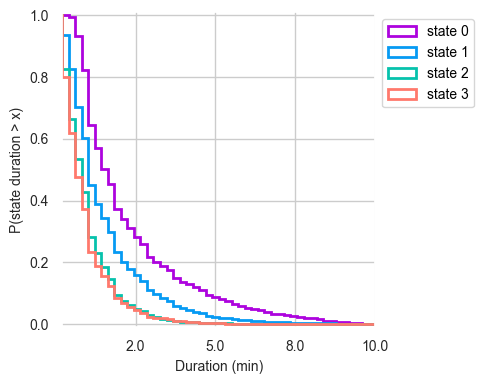

In [109]:
# plot ar-HMM state durations 
# plot as exceedance curves (ccdf -- how often is the duration greater than x?)
infDurations_arHMM_ALL = computeStateDurations(fillNAwithInt(Data['arHMM_MLstates'].filled(np.nan), 25).astype(int))
    
fig,axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(5,4))

statelabels = ['state 0', 'state 1', 'state 2', 'state 3']

durBins = np.linspace(0,10*6,50)
ticklabels=np.round((10/60*np.linspace(0,durBins[-1],5))).astype(str)

[axs.hist(infDurations_arHMM_ALL[s],bins=durBins,color=arhmm_colors[s],density=True,linestyle='solid',alpha=1,histtype='step',cumulative=-1,lw=2,label=statelabels[s]) for s in range(0,4)]

axs.set_xticks(ticks=np.linspace(0,durBins[-1],5))
axs.set_xticklabels(ticklabels)
axs.set_xlim([durBins[1],durBins[-1]])
axs.set_ylim([-0.01,1.01])
axs.set_xlabel('Duration (min)')
axs.set_ylabel('P(state duration > x)')
axs.legend(bbox_to_anchor=(1, 1),loc="upper left")
axs.set_ylabel('P(state duration > x)')


if saveFigures:
    outpath = os.path.join(figpath,'arHMM_StateDurations_byState'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

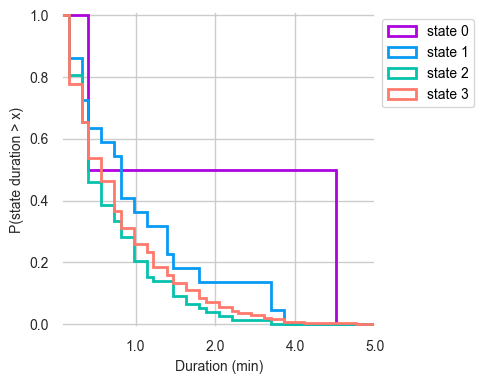

In [110]:
# plot survival curve of arHMMstates --> leaving
state0Dur = computeStateDurationsBeforeEvent(Data['arHMM_MLstates'],0.0,Data['bin_LawnExit_mostRecent'])
state1Dur = computeStateDurationsBeforeEvent(Data['arHMM_MLstates'],1.0,Data['bin_LawnExit_mostRecent'])
state2Dur = computeStateDurationsBeforeEvent(Data['arHMM_MLstates'],2.0,Data['bin_LawnExit_mostRecent'])
state3Dur = computeStateDurationsBeforeEvent(Data['arHMM_MLstates'],3.0,Data['bin_LawnExit_mostRecent'])
infDurations_arHMMstates_ALL = [state0Dur, state1Dur, state2Dur, state3Dur]

fig,axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(5,4))

statelabels = ['state 0','state 1', 'state 2', 'state 3']

durBins = np.linspace(0,5*6,50)
ticklabels=np.round((10/60*np.linspace(0,durBins[-1],5))).astype(str)

[axs.hist(infDurations_arHMMstates_ALL[s],bins=durBins,color=arhmm_colors[s],density=True,linestyle='solid',alpha=1,histtype='step',cumulative=-1,lw=2,label=statelabels[s]) for s in range(0,4)]

axs.set_xticks(ticks=np.linspace(0,durBins[-1],5))
axs.set_xticklabels(ticklabels)
axs.set_xlim([durBins[1],durBins[-1]])
axs.set_ylim([-0.01,1.01])
axs.set_xlabel('Duration (min)')
axs.set_ylabel('P(state duration > x)')
axs.legend(bbox_to_anchor=(1, 1),loc="upper left")
axs.set_ylabel('P(state duration > x)')

if saveFigures:
    outpath = os.path.join(figpath,'arHMM_SurvivalToLeavingDuration_byState'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

0.0005381788058909266, ***


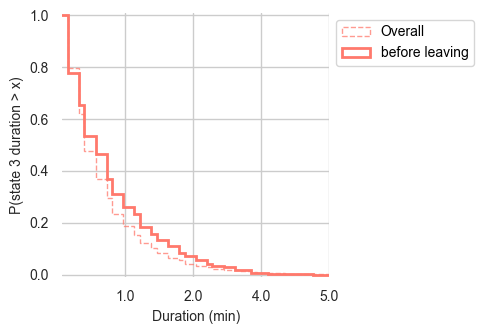

In [111]:
#Compare State 3 durations overall and before Leaving
from scipy.stats import ks_2samp
fig,axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(5,3.5))

durBins = np.linspace(0,5*6,50)
ticklabels=np.round((10/60*np.linspace(0,durBins[-1],5))).astype(str)

infDurations_arHMM_ALL = computeStateDurations(fillNAwithInt(Data['arHMM_MLstates'].filled(np.nan), 25).astype(int))
axs.hist(infDurations_arHMM_ALL[3],bins=durBins,color=arhmm_colors[3],density=True,linestyle='dashed',alpha=0.75,histtype='step',cumulative=-1,lw=1,label='Overall')

state3DurbL = computeStateDurationsBeforeEvent(Data['arHMM_MLstates'],3.0,Data['bin_LawnExit_mostRecent'])
axs.hist(state3DurbL,bins=durBins,color=arhmm_colors[3],density=True,linestyle='solid',alpha=1,histtype='step',cumulative=-1,lw=2,label='before leaving')

plt.box(False)
axs.set_xticks(ticks=np.linspace(0,durBins[-1],5))
axs.set_xticklabels(ticklabels)
axs.set_xlim([durBins[1],durBins[-1]])
axs.set_ylim([-0.01,1.01])
axs.set_xlabel('Duration (min)')
axs.set_ylabel('P(state 3 duration > x)')
axs.legend(bbox_to_anchor=(1, 1),loc="upper left")
if saveFigures:
    outpath = os.path.join(figpath,'state3_Durations'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)


#Perform a Kolmogorov-Smirnov 2sample test 
_,pval = ks_2samp(infDurations_arHMM_ALL[3], state3DurbL, alternative='two-sided')
print(str(pval)+', '+categorizePValue(pval))    


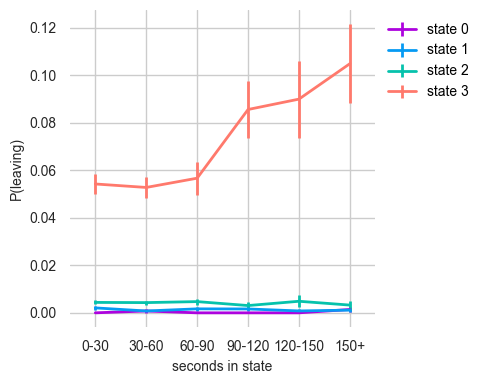

In [112]:
#probability of leaving given arHMM state for X amount of time
#for a given bin of time durations:
#     fraction of roaming intervals resulting in leaving / total roaming event 

infDurations_arHMM_ALL = computeStateDurations(fillNAwithInt(Data['arHMM_MLstates'].filled(np.nan), 25).astype(int))

state0Dur_bL = computeStateDurationsBeforeEvent(Data['arHMM_MLstates'],0.0,Data['bin_LawnExit_mostRecent'])
state1Dur_bL = computeStateDurationsBeforeEvent(Data['arHMM_MLstates'],1.0,Data['bin_LawnExit_mostRecent'])
state2Dur_bL = computeStateDurationsBeforeEvent(Data['arHMM_MLstates'],2.0,Data['bin_LawnExit_mostRecent'])
state3Dur_bL = computeStateDurationsBeforeEvent(Data['arHMM_MLstates'],3.0,Data['bin_LawnExit_mostRecent'])
infDurations_arHMM_beforeLeaving = [state0Dur_bL, state1Dur_bL, state2Dur_bL, state3Dur_bL]
statelabels = ['state 0','state 1', 'state 2', 'state 3']

maxDuration = 3 #minutes
binsize =  0.5#minutes
minuteBins = np.concatenate((np.arange(0,maxDuration*6,binsize*6),[240]))
binsToPlot = np.concatenate((minuteBins[:-1],[minuteBins[-2]+binsize*6]))

arHMM_fracLeavingPerBin = [getProbLeavingvsTimeinState(infDurations_arHMM_beforeLeaving[i],infDurations_arHMM_ALL[i],minuteBins) for i in range(len(statelabels))]

fig,axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(5,4))
for i in range(len(statelabels)):
    axs.errorbar(binsToPlot[1:]/6,arHMM_fracLeavingPerBin[i][0], yerr=arHMM_fracLeavingPerBin[i][1],color=arhmm_colors[i],label=statelabels[i],lw=2)
plt.box(False)
axs.set_xticks(np.arange(0,maxDuration+binsize,binsize))
binlabels = ['_','0-30','30-60','60-90','90-120','120-150','150+']
axs.set_xticklabels(binlabels)
axs.set_xlim([binsize-binsize/2,maxDuration+binsize/2])
axs.set_xlabel('seconds in state')
axs.set_ylabel('P(leaving)')
axs.legend(bbox_to_anchor=(1, 1),loc="upper left",frameon=False)

if saveFigures:
    outpath = os.path.join(figpath,'arHMM_pLeavingvsStateDuration'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

/Users/eliasscheer/PycharmProjects/lawnleaving/commonFunctions.py:1270: RuntimeWarning: invalid value encountered in true_divide
  probStateAligned = np.array([(numer[k] / denom[k]) for k in range(0, len(timeLine))]).reshape(len(timeLine), num_states).T
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/statsmodels/stats/proportion.py:256: RuntimeWarning: invalid value encountered in true_divide
  proportions = counts / n
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/numpy/ma/core.py:1184: RuntimeWarning: invalid value encountered in multiply
  masked_da = umath.multiply(m, da)
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/eliasscheer/PycharmProjects/lawnleaving/commonFunctions.py:1270: RuntimeWarning

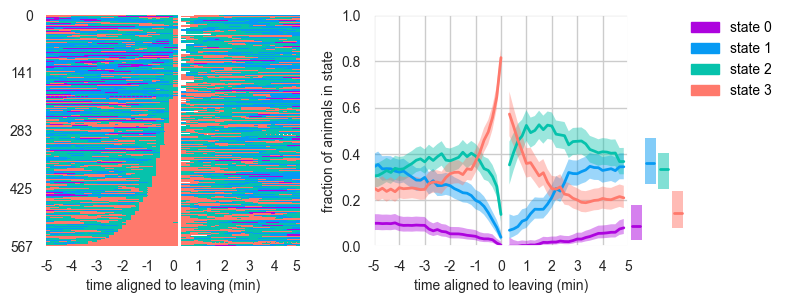

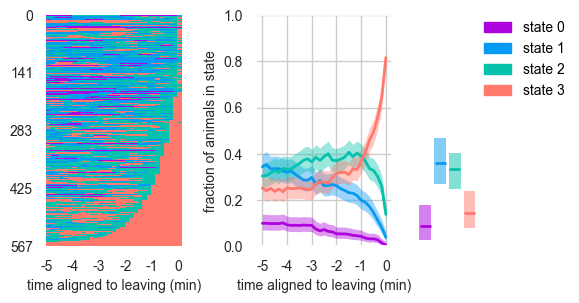

In [113]:
#show state alignments to lawn leaving and headpoke+rev
import matplotlib.pyplot as plt
binsPerMin = 6

#align data to HPREV and LL
binHeadPokeRev = Data['bin_HeadPokeRev']
binLawnExit = Data['bin_LawnExit_mostRecent']
# binLawnExit = findMostRecentInLawnforLL(binLawnExit>0,3,~Data['InLawnRunMask'])
numMins = 5
binTimeBefore = (numMins*6) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = (numMins*6) # X minutes after
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],binLawnExit>0,binTimeBefore,binTimeAfter,dtype=float)

xticksToPlot = np.hstack((binTimeLine[0:-1:binsPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*binsPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / binsPerMin).astype(int)

figsize = (9,3)
f, ax = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios': [3,3,0.5],'hspace':0,'wspace':0.4})
ax,_ = plotMLstates_Aligned_masked(ax,Data['arHMM_MLstates'],arHMM_model,~Data['InLawnRunMask'],binLawnExit,binTimeLine,binTimeBefore,binTimeAfter,binsPerMin,'',arhmm_colors,numLastBins,False,figsize=figsize)

ax[0], StateByAligned = plotMLstateHeatmap_durSort(ax[0], 
                                      Data['arHMM_MLstates'],
                                      3.0,
                                      ~Data['InLawnRunMask'], 
                                      Data['bin_LawnExit_mostRecent'], 
                                      binsPerMin, 
                                      binTimeBefore, 
                                      binTimeAfter, 
                                      arHMM_model,
                                      arhmm_colors)


ax[0].set_xticks(xticksToPlot + binTimeBefore)
ax[0].set_xticklabels(xtickLabels,rotation=0)

ax[1].set_xticks(xtickLabels)
ax[1].set_xticklabels(xtickLabels)
ax[1].set_xlim(-numMins,numMins)
ax[1].set_ylim(0,1)
ax[0].set_xlabel('time aligned to leaving (min)')
ax[1].set_xlabel('time aligned to leaving (min)')
# ax[1].set_ylabel('fraction of animals in state')


#get all R/D values so we can generate barplots with confidence intervals
MLstates_overall = Data['arHMM_MLstates']
fracstate0_leavers = np.nanmean(MLstates_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==0.0,axis=1)
fracstate1_leavers = np.nanmean(MLstates_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==1.0,axis=1)
fracstate2_leavers = np.nanmean(MLstates_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==2.0,axis=1)
fracstate3_leavers = np.nanmean(MLstates_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==3.0,axis=1)

fracARHMMstates = [fracstate0_leavers,fracstate1_leavers,fracstate2_leavers,fracstate3_leavers]
fracARHMMstates_stacked = pd.DataFrame(data=stack_padding(fracARHMMstates).T,columns=['state 0','state 1','state 2','state 3'])

###########
#plot accompanying boxplots #change this to have the same look as the plots with SEM
g = sns.boxplot(data=fracARHMMstates_stacked,
            showfliers=False,
            whis=0,
            palette = colors,
            saturation = 1,
            ax = ax[2])

# DIY custom boxplot
for i,box in enumerate(g.artists):
    box.set_edgecolor(mpl.colors.to_rgba(arhmm_colors[i], 0))
    box.set_facecolor(mpl.colors.to_rgba(arhmm_colors[i], 0.50))
    # iterate over whiskers and median lines
    for j in g.lines:
         j.set_color(mpl.colors.to_rgba(colors[i], 0))

#make the medians pop
m_width = 0.6
medians = fracARHMMstates_stacked.melt().groupby("variable").median().reindex(['state 0','state 1','state 2','state 3'])
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= arhmm_colors[i], linestyle='-', linewidth=2,zorder=3)

ax[2].set_frame_on(False)
ax[2].set_xticks([])
ax[2].set_ylim(0,1)
ax[2].set_yticks([]) 
##################

#move axes around
box = ax[2].get_position()
ax[2].set_position([box.x0-0.08, box.y0, box.width*1.3, box.height])
ax[2].set_frame_on(False)
ax[2].set_xticks([])
# create color map with colors and df.names
cmap = dict(zip(fracARHMMstates_stacked.columns, arhmm_colors))
# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
# add the legend
ax[2].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)


folderName = 'featuresAlignedtoLawnLeaving'
sub_subfolder = os.path.join(figpath,folderName)
if saveFigures:
    outpath = os.path.join(sub_subfolder,'arHMM_model'+'_kappa_'+str(arHMM_model.transitions.kappa)+'_numstates_'+str(arHMM_model.K)+'_StatesAlignedToLeaving_'+str(numMins)+'minBeforeAndAfter'+'_'+datestring)
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(), bbox_inches='tight')
    plt.savefig(outpath+'.pdf',bbox_extra_artists=(), bbox_inches='tight')
    
#########
#just 5 minutes before
# binLawnExit = findMostRecentInLawnforLL(binLawnExit>0,3,~Data['InLawnRunMask'])
numMins = 5
binTimeBefore = (numMins*6) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = 1 # X minutes after
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],binLawnExit>0,binTimeBefore,binTimeAfter,dtype=float)

xticksToPlot = np.hstack((binTimeLine[0:-1:binsPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*binsPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / binsPerMin).astype(int)


f, ax = plt.subplots(1, 3, figsize=(6,3), gridspec_kw={'width_ratios': [3,3,1],'hspace':0,'wspace':0.7})
ax,_ = plotMLstates_Aligned_masked(ax,Data['arHMM_MLstates'],arHMM_model,~Data['InLawnRunMask'],binLawnExit,binTimeLine,binTimeBefore,binTimeAfter,binsPerMin,'',arhmm_colors,numLastBins,False,figsize=figsize)

ax[0], StateByAligned = plotMLstateHeatmap_durSort(ax[0], 
                                      Data['arHMM_MLstates'],
                                      3.0,
                                      ~Data['InLawnRunMask'], 
                                      Data['bin_LawnExit_mostRecent'], 
                                      binsPerMin, 
                                      binTimeBefore, 
                                      binTimeAfter, 
                                      arHMM_model,
                                      arhmm_colors)

ax[0].set_xticks(xticksToPlot + binTimeBefore)
ax[0].set_xticklabels(xtickLabels,rotation=0)

ax[1].set_xticks(xtickLabels)
ax[1].set_xticklabels(xtickLabels)
ax[1].set_ylim(0,1)
ax[0].set_xlabel('time aligned to leaving (min)')
ax[1].set_xlabel('time aligned to leaving (min)')
# ax[1].set_ylabel('fraction of animals in state')


#get all R/D values so we can generate barplots with confidence intervals
MLstates_overall = Data['arHMM_MLstates']
fracstate0_leavers = np.nanmean(MLstates_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==0.0,axis=1)
fracstate1_leavers = np.nanmean(MLstates_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==1.0,axis=1)
fracstate2_leavers = np.nanmean(MLstates_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==2.0,axis=1)
fracstate3_leavers = np.nanmean(MLstates_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==3.0,axis=1)

fracARHMMstates = [fracstate0_leavers,fracstate1_leavers,fracstate2_leavers,fracstate3_leavers]
fracARHMMstates_stacked = pd.DataFrame(data=stack_padding(fracARHMMstates).T,columns=['state 0','state 1','state 2','state 3'])

###########
#plot accompanying boxplots #change this to have the same look as the plots with SEM
g = sns.boxplot(data=fracARHMMstates_stacked,
            showfliers=False,
            whis=0,
            palette = colors,
            saturation = 1,
            ax = ax[2])

# DIY custom boxplot
for i,box in enumerate(g.artists):
    box.set_edgecolor(mpl.colors.to_rgba(arhmm_colors[i], 0))
    box.set_facecolor(mpl.colors.to_rgba(arhmm_colors[i], 0.50))
    # iterate over whiskers and median lines
    for j in g.lines:
         j.set_color(mpl.colors.to_rgba(colors[i], 0))

#make the medians pop
m_width = 0.6
medians = fracARHMMstates_stacked.melt().groupby("variable").median().reindex(['state 0','state 1','state 2','state 3'])
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= arhmm_colors[i], linestyle='-', linewidth=2,zorder=3)

ax[2].set_frame_on(False)
ax[2].set_xticks([])
ax[2].set_ylim(0,1)
ax[2].set_yticks([]) 
##################

#move axes around
box = ax[2].get_position()
ax[2].set_position([box.x0-0.08, box.y0, box.width*1.3, box.height])
ax[2].set_frame_on(False)
ax[2].set_xticks([])
# create color map with colors and df.names
cmap = dict(zip(fracARHMMstates_stacked.columns, arhmm_colors))
# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
# add the legend
ax[2].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)


folderName = 'featuresAlignedtoLawnLeaving'
sub_subfolder = os.path.join(figpath,folderName)
if saveFigures:
    outpath = os.path.join(sub_subfolder,'arHMM_model'+'_kappa_'+str(arHMM_model.transitions.kappa)+'_numstates_'+str(arHMM_model.K)+'_StatesAlignedToLeaving_'+str(numMins)+'minBefore'+'_'+datestring)
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(), bbox_inches='tight')
    plt.savefig(outpath+'.pdf',bbox_extra_artists=(), bbox_inches='tight')



In [114]:
#fraction of time roaming only among leavers
leaverIdx = np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]
fracState0_leavers = pd.DataFrame(np.mean((Data['arHMM_MLstates']==0.0)[leaverIdx,:],axis=1))
fracState1_leavers = pd.DataFrame(np.mean((Data['arHMM_MLstates']==1.0)[leaverIdx,:],axis=1))
fracState2_leavers = pd.DataFrame(np.mean((Data['arHMM_MLstates']==2.0)[leaverIdx,:],axis=1))
fracState3_leavers = pd.DataFrame(np.mean((Data['arHMM_MLstates']==3.0)[leaverIdx,:],axis=1))


/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/seaborn/matrix.py:332: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
<ipython-input-115-cc73250290c6>:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(), bbox_inches='tight')
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


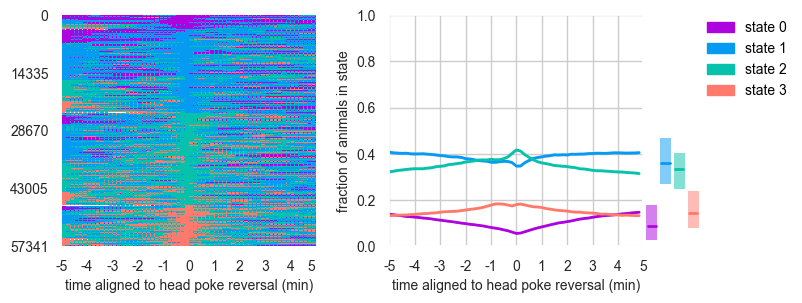

In [115]:
## AR-HMM states Aligned to Headpoke Reversal
numMins = 5
binTimeBefore = (numMins*6) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = (numMins*6) # X minutes after
bin_Midbody_fspeed_LLaligned, binMask_LLaligned, binTimeLine, binAlignIdx = alignData_masked(Data['bin_Midbody_fspeed'],~Data['InLawnRunMask'],binLawnExit>0,binTimeBefore,binTimeAfter,dtype=float)

xticksToPlot = np.hstack((binTimeLine[0:-1:binsPerMin], binTimeLine[-1]))
# xticksToPlot = np.hstack((binTimeLine[0:-1:2*binsPerMin], binTimeLine[-1])) #for 10 minutes
xtickLabels = np.ceil(xticksToPlot / binsPerMin).astype(int)

figsize=(9,3)

f, ax = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios': [3,3,0.5],'hspace':0,'wspace':0.4})
ax,_ = plotMLstates_Aligned_masked(ax,Data['arHMM_MLstates'],arHMM_model,~Data['InLawnRunMask'],binHeadPokeRev>0,binTimeLine,binTimeBefore,binTimeAfter,binsPerMin,'',arhmm_colors,numLastBins,False,figsize=figsize)
ax[0].set_xticks(xticksToPlot + binTimeBefore)
ax[0].set_xticklabels(xtickLabels,rotation=0)

ax[1].set_xticks(xtickLabels)
ax[1].set_xticklabels(xtickLabels)
ax[1].set_xlim(-numMins,numMins)
ax[1].set_ylim(0,1)
ax[0].set_xlabel('time aligned to head poke reversal (min)')
ax[1].set_xlabel('time aligned to head poke reversal (min)')
# ax[1].set_ylabel('fraction of animals in state')


#get all R/D values so we can generate barplots with confidence intervals
MLstates_overall = Data['arHMM_MLstates']
fracstate0_leavers = np.nanmean(MLstates_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==0.0,axis=1)
fracstate1_leavers = np.nanmean(MLstates_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==1.0,axis=1)
fracstate2_leavers = np.nanmean(MLstates_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==2.0,axis=1)
fracstate3_leavers = np.nanmean(MLstates_overall[np.where(np.sum(Data['bin_LawnExit_mostRecent'],axis=1)>0)[0]]==3.0,axis=1)

fracARHMMstates = [fracstate0_leavers,fracstate1_leavers,fracstate2_leavers,fracstate3_leavers]
fracARHMMstates_stacked = pd.DataFrame(data=stack_padding(fracARHMMstates).T,columns=['state 0','state 1','state 2','state 3'])

###########
#plot accompanying boxplots #change this to have the same look as the plots with SEM
g = sns.boxplot(data=fracARHMMstates_stacked,
            showfliers=False,
            whis=0,
            palette = colors,
            saturation = 1,
            ax = ax[2])

# DIY custom boxplot
for i,box in enumerate(g.artists):
    box.set_edgecolor(mpl.colors.to_rgba(arhmm_colors[i], 0))
    box.set_facecolor(mpl.colors.to_rgba(arhmm_colors[i], 0.50))
    # iterate over whiskers and median lines
    for j in g.lines:
         j.set_color(mpl.colors.to_rgba(colors[i], 0))

#make the medians pop
m_width = 0.6
medians = fracARHMMstates_stacked.melt().groupby("variable").median().reindex(['state 0','state 1','state 2','state 3'])
for i,xtick in enumerate(g.get_xticks()):
    g.plot([xtick-m_width/2, xtick+m_width/2], [medians.iloc[i], medians.iloc[i]], color= arhmm_colors[i], linestyle='-', linewidth=2,zorder=3)

ax[2].set_frame_on(False)
ax[2].set_xticks([])
ax[2].set_ylim(0,1)
ax[2].set_yticks([]) 
##################

#move axes around
box = ax[2].get_position()
ax[2].set_position([box.x0-0.08, box.y0, box.width*1.3, box.height])
ax[2].set_frame_on(False)
ax[2].set_xticks([])
# create color map with colors and df.names
cmap = dict(zip(fracARHMMstates_stacked.columns, arhmm_colors))
# create the rectangles for the legend
patches = [Patch(color=v, label=k) for k, v in cmap.items()]
# add the legend
ax[2].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0,frameon=False)


folderName = 'featuresAlignedtoHPREV_LLylim'
sub_subfolder = os.path.join(figpath,folderName)
if saveFigures:
    outpath = os.path.join(sub_subfolder,'arHMM_model_StatesAlignedToHPREV_'+str(numMins)+'minBeforeAndAfter'+'_'+datestring)
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(), bbox_inches='tight')
#     plt.savefig(outpath+'.pdf')

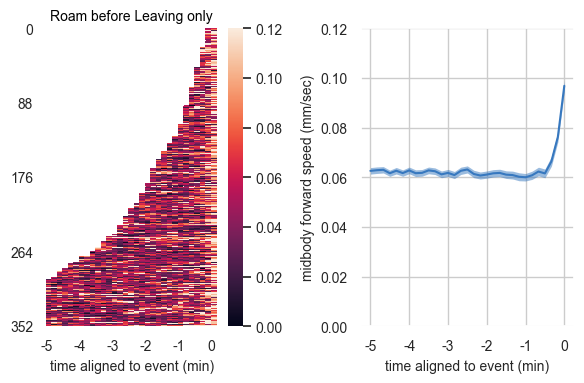

In [116]:
#Plot Roaming Speed before Leaving (only last roam before leaving)
binsPerMin = 6
numMins = 5
binTimeBefore = (numMins*binsPerMin) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = 1#(numMins*binsPerMin) # X minutes after

_, MLstatesRuns = getStateRunsBeforeEvent(Data['RD_states_Matrix_exog_Cent'],True,Data['bin_LawnExit_mostRecent'])

binLawnExit_roam = np.logical_and(Data['bin_LawnExit_mostRecent'],Data['RD_states_Matrix_exog_Cent']) #subselect lawn exits that derive from roaming states

LastRoam_inLawn = np.logical_and(~MLstatesRuns.mask,Data['InLawnRunMask']) #True and True, invert it for the mask

LL_aligned, mask_aligned, binTimeLine, binAlignIdx = \
alignData_masked_lastRunOnly(Data['bin_Midbody_fspeed'], ~LastRoam_inLawn, binLawnExit_roam, binTimeBefore, binTimeAfter, dtype=float)

ymin = 0
ymax = 0.12
fig,axs = plt.subplots(1,2,figsize=(6,4))
axs = plotAligned_masked(axs, LL_aligned, binTimeLine, binTimeBefore,ymin, ymax, binsPerMin, 'midbody forward speed (mm/sec)', 'Roam before Leaving only', colors, "length",
                            False, binAlignIdx, binTimeBefore,True,0.9)

axs[1].set_ylim([ymin, ymax])

folderName = 'featuresAlignedtoLawnLeaving'
sub_subfolder = os.path.join(figpath,folderName)
if saveFigures:
    outpath = os.path.join(sub_subfolder,'MidbodyFSpeed_LastRoamOnly_AlignedToLeaving_'+str(numMins)+'minBeforeAndAfter'+'_'+datestring)
    plt.savefig(outpath+'.pdf',bbox_extra_artists=(), bbox_inches='tight')
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(), bbox_inches='tight')


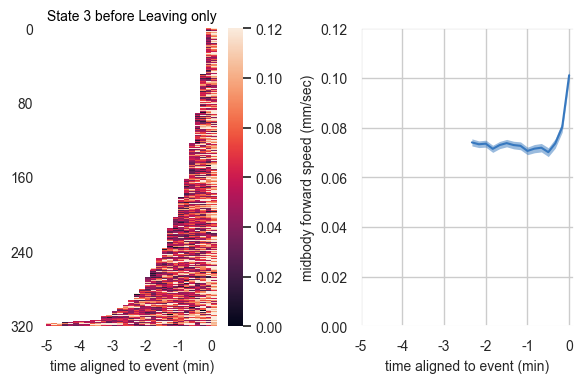

In [117]:
#Plot State 3 Speed before Leaving (only last roam before leaving)
binsPerMin = 6
numMins = 5
binTimeBefore = (numMins*binsPerMin) # X minutes before (3 fps)
numLastBins= binTimeBefore
binTimeAfter = 1#(numMins*binsPerMin) # X minutes after

_, MLstatesRuns = getStateRunsBeforeEvent(Data['arHMM_MLstates'],3.0,Data['bin_LawnExit_mostRecent'])

binLawnExit_state3 = np.logical_and(Data['bin_LawnExit_mostRecent'],Data['arHMM_MLstates']==3.0) #subselect lawn exits that derive from roaming states

LastState3_inLawn = np.logical_and(~MLstatesRuns.mask,Data['InLawnRunMask']) #True and True, invert it for the mask

LL_aligned, mask_aligned, binTimeLine, binAlignIdx = \
alignData_masked_lastRunOnly(Data['bin_Midbody_fspeed'], ~LastState3_inLawn, binLawnExit_state3, binTimeBefore, binTimeAfter, dtype=float)

ymin = 0
ymax = 0.12
fig,axs = plt.subplots(1,2,figsize=(6,4))
axs = plotAligned_masked(axs, LL_aligned, binTimeLine, binTimeBefore,ymin, ymax, binsPerMin, 'midbody forward speed (mm/sec)', 'State 3 before Leaving only', colors, "length",
                            False, binAlignIdx, binTimeBefore,True,0.9)

# axs = plotAligned(axs, LL_aligned, binTimeLine, binTimeBefore, ymin, ymax, 'midbody forward speed (mm/sec)', 'Roam before Leaving only', colors, True,
#                             False, binAlignIdx, binTimeBefore)

axs[1].set_ylim([ymin, ymax])

folderName = 'featuresAlignedtoLawnLeaving'
sub_subfolder = os.path.join(figpath,folderName)
if saveFigures:
    outpath = os.path.join(sub_subfolder,'MidbodyFSpeed_LastState3Only_AlignedToLeaving_'+str(numMins)+'minBeforeAndAfter'+'_'+datestring)
    plt.savefig(outpath+'.pdf',bbox_extra_artists=(), bbox_inches='tight')
    plt.savefig(outpath+'.png',dpi=300,bbox_extra_artists=(), bbox_inches='tight')


1.3129660218731408e-19, ****


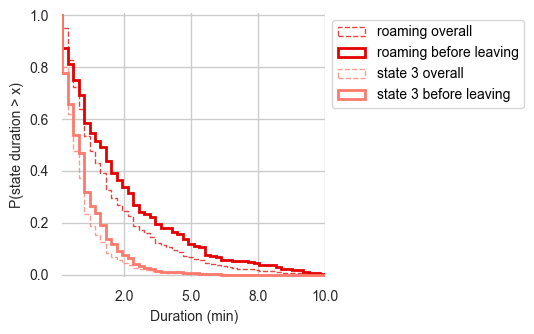

In [118]:
#Compare durations of roam to leaving TO state 3 to leaving

from scipy.stats import ks_2samp
fig,axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(5.5,3.5))

durBins = np.linspace(0,10*6,50)
ticklabels=np.round((10/60*np.linspace(0,durBins[-1],5))).astype(str)

infDurations_RD_ALL = computeStateDurations(Data['RD_states_Matrix_exog_Cent'].astype(int).filled(25))
axs.hist(infDurations_RD_ALL[1],bins=durBins,color=colors[1],density=True,linestyle='dashed',alpha=0.75,histtype='step',cumulative=-1,lw=1,label='roaming overall')
roamDurbL = computeStateDurationsBeforeEvent(Data['RD_states_Matrix_exog_Cent'],True,Data['bin_LawnExit_mostRecent'])
axs.hist(roamDurbL,bins=durBins,color=colors[1],density=True,linestyle='solid',alpha=1,histtype='step',cumulative=-1,lw=2,label='roaming before leaving')

infDurations_arHMM_ALL = computeStateDurations(fillNAwithInt(Data['arHMM_MLstates'].filled(np.nan), 25).astype(int))
axs.hist(infDurations_arHMM_ALL[3],bins=durBins,color=arhmm_colors[3],density=True,linestyle='dashed',alpha=0.75,histtype='step',cumulative=-1,lw=1,label='state 3 overall')
state3DurbL = computeStateDurationsBeforeEvent(Data['arHMM_MLstates'],3.0,Data['bin_LawnExit_mostRecent'])
axs.hist(state3DurbL,bins=durBins,color=arhmm_colors[3],density=True,linestyle='solid',alpha=1,histtype='step',cumulative=-1,lw=2,label='state 3 before leaving')


plt.box(False)
axs.set_xticks(ticks=np.linspace(0,durBins[-1],5))
axs.set_xticklabels(ticklabels)
axs.set_xlim([durBins[1],durBins[-1]])
axs.set_ylim([-0.01,1.01])
# axs.set_yscale("log", basey=10)
axs.set_xlabel('Duration (min)')
axs.set_ylabel('P(state duration > x)')
axs.legend(bbox_to_anchor=(1, 1),loc="upper left")
if saveFigures:
    outpath = os.path.join(figpath,'Roam_vs_State3_Durations'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

#Perform a Kolmogorov-Smirnov 2sample test 
_,pval = ks_2samp(state3DurbL, roamDurbL, alternative='two-sided')
print(str(pval)+', '+categorizePValue(pval))    


In [119]:
infDurations_RD_ALL = computeStateDurations(Data['RD_states_Matrix_exog_Cent'].astype(int).filled(25))
infDurations_arHMM_ALL = computeStateDurations(fillNAwithInt(Data['arHMM_MLstates'].filled(np.nan), 25).astype(int))
infDurations_combined = infDurations_RD_ALL[0:2]+infDurations_arHMM_ALL[0:4]


In [120]:
combined_colors = colors[0:2]+arhmm_colors

In [121]:
len(infDurations_arHMM_ALL)

26

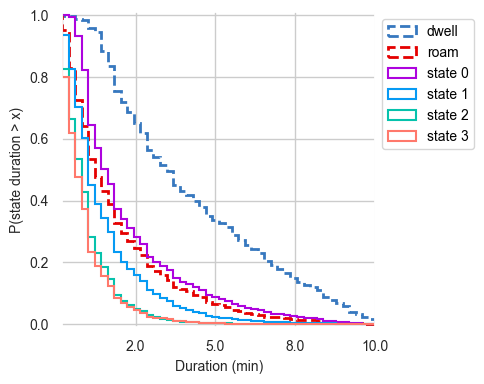

In [122]:
#Compare state durations of roam/dwell and AR-HMM

# plot ar-HMM state durations 
# plot as exceedance curves (ccdf -- how often is the duration greater than x?)
infDurations_RD_ALL = computeStateDurations(Data['RD_states_Matrix_exog_Cent'].astype(int).filled(25))
infDurations_arHMM_ALL = computeStateDurations(fillNAwithInt(Data['arHMM_MLstates'].filled(np.nan), 25).astype(int))
infDurations_combined = infDurations_RD_ALL[0:2]+infDurations_arHMM_ALL[0:4]

statelabels = ['dwell','roam','state 0', 'state 1', 'state 2', 'state 3']
combined_colors = colors[0:2]+arhmm_colors

fig,axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(5,4))


durBins = np.linspace(0,10*6,50)
ticklabels=np.round((10/60*np.linspace(0,durBins[-1],5))).astype(str)

for s in range(0,len(infDurations_combined)):
    if s<2:
        axs.hist(infDurations_combined[s],bins=durBins,color=combined_colors[s],density=True,linestyle='dashed',alpha=1,histtype='step',cumulative=-1,lw=2,label=statelabels[s]) 
    else:
        axs.hist(infDurations_combined[s],bins=durBins,color=combined_colors[s],density=True,linestyle='solid',alpha=1,histtype='step',cumulative=-1,lw=1.5,label=statelabels[s]) 
axs.set_xticks(ticks=np.linspace(0,durBins[-1],5))
axs.set_xticklabels(ticklabels)
axs.set_xlim([durBins[1],durBins[-1]])
axs.set_ylim([-0.01,1.01])
axs.set_xlabel('Duration (min)')
axs.set_ylabel('P(state duration > x)')
axs.legend(bbox_to_anchor=(1, 1),loc="upper left")
axs.set_ylabel('P(state duration > x)')


if saveFigures:
    outpath = os.path.join(figpath,'RD_arHMM_StateDurations_Comparison'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

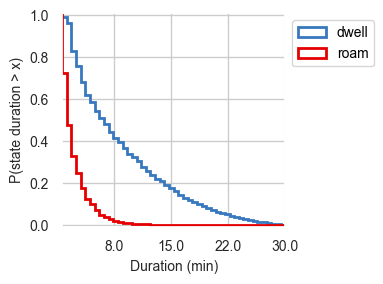

In [123]:
# Roaming and Dwelling State Durations alone
fig,axs = plt.subplots(1, 1, sharey=False, tight_layout=True, figsize=(4,3))

RDlabels = ['dwell','roam']

durBins = np.linspace(0,30*6,50)
ticklabels=np.round((10/60*np.linspace(0,durBins[-1],5))).astype(str)

[axs.hist(infDurations_RD_ALL[s],bins=durBins,color=colors[s],density=True,linestyle='solid',alpha=1,histtype='step',cumulative=-1,lw=2,label=RDlabels[s]) for s in range(0,2)]

axs.set_xticks(ticks=np.linspace(0,durBins[-1],5))
axs.set_xticklabels(ticklabels)
axs.set_xlim([durBins[1],durBins[-1]])
axs.set_ylim([-0.01,1.01])
axs.set_xlabel('Duration (min)')
axs.set_ylabel('P(state duration > x)')
axs.legend(bbox_to_anchor=(1, 1),loc="upper left")
axs.set_ylabel('P(state duration > x)')


if saveFigures:
    outpath = os.path.join(figpath,'RoamDwell_Cent_StateDurations_byState'+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

## Comparing behavioral state systems

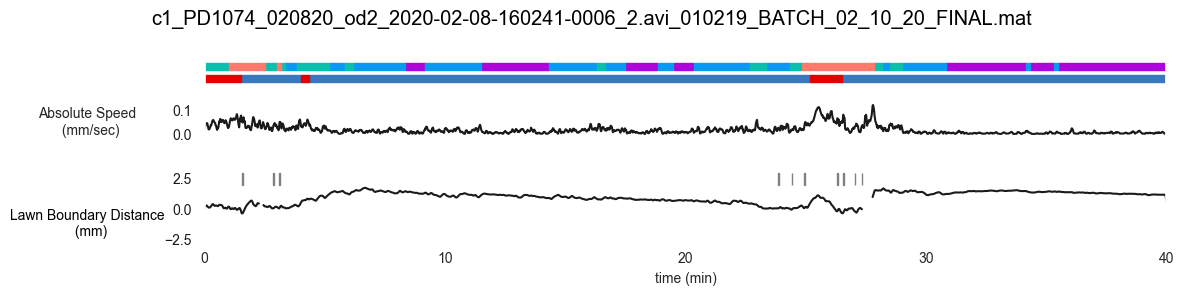

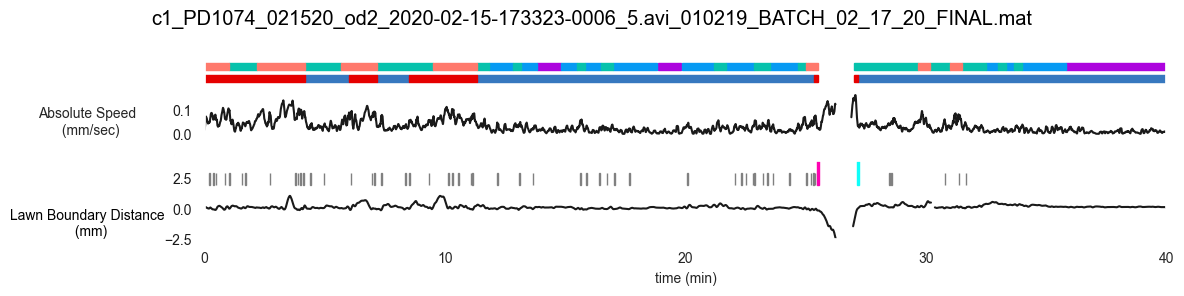

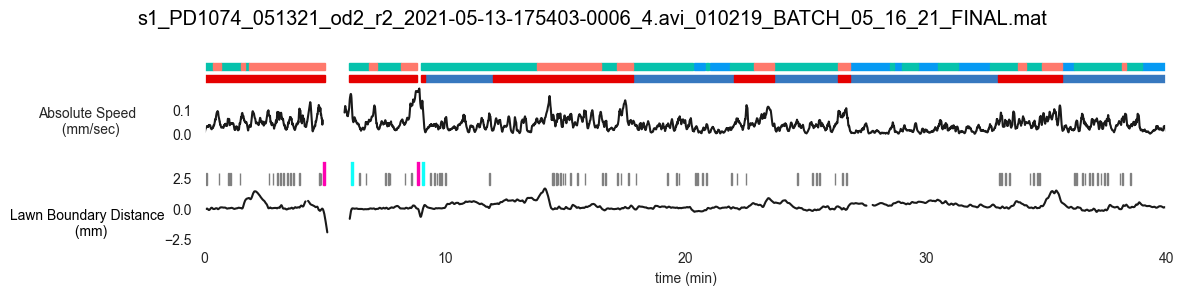

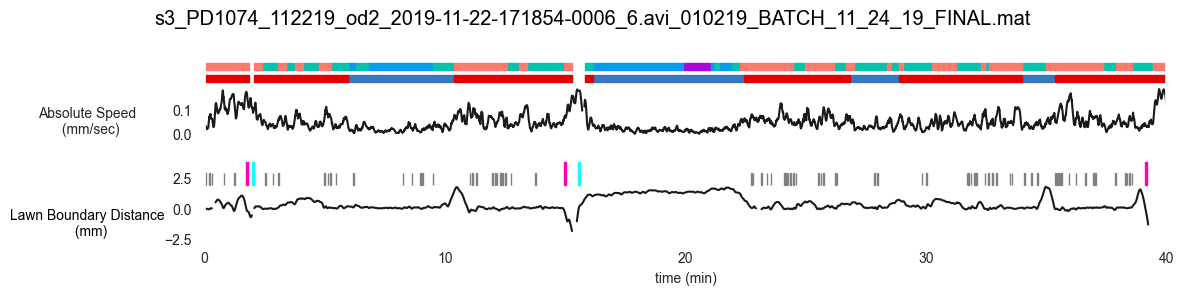

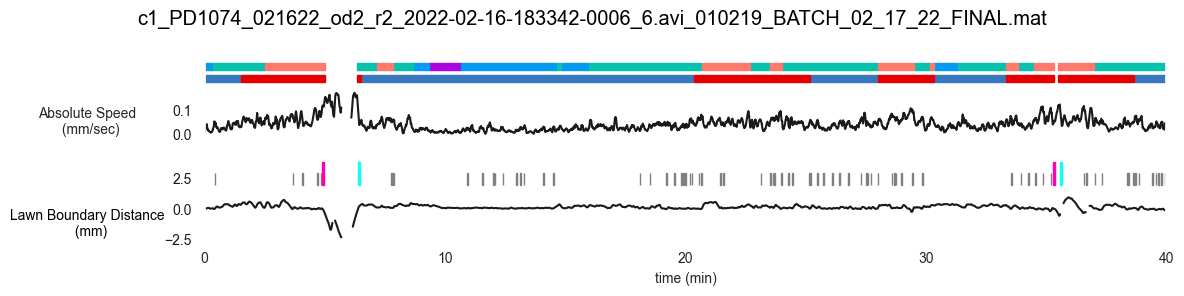

In [124]:
#Plot sample traces with RD annotation

#show example track annotations of roaming and dwelling in UL and LL data
from matplotlib.patches import Rectangle

timeLine = np.linspace(0,40,7200)
xtickSpots = np.linspace(0,len(timeLine-1),5).astype(int)
xtickSpots[-1] = xtickSpots[-1]-1
xtickLabels = np.round(timeLine[xtickSpots]).astype(int).astype(str)

#make a subfolder to save these figures
separator = ','
genNames = separator.join(genotypes)
folderName = 'single traces (state annotations)'
sub_subfolder = os.path.join(figpath,folderName)
if not os.path.exists(sub_subfolder):
    os.makedirs(sub_subfolder)

# randomIdx = np.random.choice(np.arange(len(Data['matfilename'])),20,replace=False)
# for idx in range(Data['Centroid_speed'].shape[0]):
randomIdx = [1,10,500,736,1013]
for idx in randomIdx:
    ################ Start with Centroid-related measurements
    Speed_midbody = movMean(abs(Data['Midbody_speed'][idx]),15)
    AngSpeed_midbody = (Data['Midbody_angspeed'][idx])
    RD_midbody = Data['RD_states_Matrix_exog'][idx].astype(int).filled(25).reshape(1,-1)
    RD_midbody = np.repeat(RD_midbody,binSize)
    
    Speed_cent = movMean(abs(Data['Centroid_speed'][idx]),15)
    AngSpeed_cent = (Data['Centroid_angspeed'][idx])
    RD_cent = Data['RD_states_Matrix_exog_Cent'][idx].astype(int).filled(25).reshape(1,-1)
    RD_cent = np.repeat(RD_cent,binSize)
    
    outpath = os.path.join(sub_subfolder,Data['matfilename'].iloc[idx][0][:-4]+"_RDstates.csv")
    np.savetxt(outpath, RD_cent, delimiter=",")

    BacDensity_head = movMean(Data['Bacterial_Density'][idx],15)
    ML = Data['arHMM_MLstates'][idx].astype(int).filled(25).reshape(1,-1)
    ML = np.repeat(ML,binSize)
    
    outpath = os.path.join(sub_subfolder,Data['matfilename'].iloc[idx][0][:-4]+"_arHMMstates.csv")
    np.savetxt(outpath, ML, delimiter=",")

    fig, axs = plt.subplots(2,1,figsize=(12,3),sharex=True)

    axs[0].set_facecolor('w')
    startIdx = 0
    endIdx = 7200

    #plot RD bouts
    for i in range(RD_hmm_Cent_exog.K):
        stateIntervals = get_intervals(RD_cent==i,0)
        if stateIntervals.size>0:
            intLen = stateIntervals[:,1]-stateIntervals[:,0]
            for intV, intL in zip(stateIntervals,intLen):
                axs[0].add_patch(Rectangle((intV[0], 0.22), intL, 0.03,edgecolor=colors[i], facecolor=colors[i])) 

    #plot arHMM bouts
    for i in range(arHMM_model.K):
        stateIntervals = get_intervals(ML==i,0)
        if stateIntervals.size>0:
            intLen = stateIntervals[:,1]-stateIntervals[:,0]
            for intV, intL in zip(stateIntervals,intLen):
                axs[0].add_patch(Rectangle((intV[0], 0.27), intL, 0.03,edgecolor=arhmm_colors[i], facecolor=arhmm_colors[i])) 
    
    color='black'
    axs[0].grid(b=None)
    axs[0].plot(Speed_cent,color='k',lw=1.5)
    axs[0].set_xlim(0,np.where(~np.isnan(Speed_cent))[0].max())
    axs[0].set_yticks([0,0.1])
    axs[0].set_ylabel('Absolute Speed \n (mm/sec)',fontsize=10,rotation = 0)
    axs[0].yaxis.set_label_coords(-0.12,0.0)
    axs[0].tick_params(axis='y', labelcolor='k', labelsize=10)
#     axs[0].set_title('Absolute Speed ',fontsize=10,loc='left')

#     axs[1].grid(b=None)
#     axs[1].set_facecolor('w')
#     axs[1].plot(AngSpeed_cent,linewidth=1,color='k')
#     axs[1].set_yticks([0,180])
#     axs[1].set_xticks(xtickSpots)
#     axs[1].set_xticklabels(xtickLabels)
#     axs[1].tick_params(axis='y', labelcolor=color, labelsize=10)
#     axs[1].set_xlim(0,np.where(~np.isnan(Speed_cent))[0].max())
#     axs[1].set_ylabel('deg/sec',fontsize=10, rotation = 0)
#     axs[1].set_title('Angular Speed',fontsize=10,loc='left')

    if not ('uniform' in genotypes or 'UL' in genotypes):
        LawnBoundDist = movMean(Data['Lawn_Boundary_Dist'][idx],15)
        HeadpokeRev = Data['HeadPokeRev'][idx]
        HeadpokeFwd = Data['HeadPokeFwd'][idx]
        HeadpokePause = Data['HeadPokePause'][idx]
        HeadpokeAll = Data['HeadPokesAll'][idx]
        Lawn_Exit = Data['Lawn_Exit'][idx]
        Lawn_Entry = Data['Lawn_Entry'][idx]
        hprIdx = np.where(HeadpokeAll)[0]
        axs[1].set_facecolor('w')
        color = 'black'

        axs[1].grid(b=None)
        axs[1].plot(LawnBoundDist, color='k',lw=1.5)
        axs[1].set_ylim([-2.5,4])
        axs[1].tick_params(axis='y', labelcolor='k', labelsize=10)
        axs[1].set_ylabel('Lawn Boundary Distance \n (mm)',color=color, fontsize=10, rotation = 0) # we already handled the x-label with ax1
        axs[1].yaxis.set_label_coords(-0.12,0.0)
        #         axs[1].set_title('Lawn Boundary Distance', fontsize=10,loc='left')

        hprIdx = np.where(HeadpokeRev)[0]
        for h in hprIdx:
            axs[1].add_patch(Rectangle((h, 2), 5, 1,edgecolor='gray', facecolor='gray'))
#         hpfIdx = np.where(HeadpokeFwd)[0]
#         for h in hpfIdx:
#             axs[2].add_patch(Rectangle((h, 2), 5, 1,edgecolor=genotype_colors[8], facecolor=genotype_colors[8])) 
#         hppIdx = np.where(HeadpokePause)[0]
#         for h in hppIdx:
#             axs[2].add_patch(Rectangle((h, 2), 5, 1,edgecolor=genotype_colors[9], facecolor=genotype_colors[9])) 
        exitIdx = np.where(Lawn_Exit)[0]
        for e in exitIdx:
            axs[1].add_patch(Rectangle((e, 2), 15, 2,edgecolor=colors[10], facecolor=colors[10])) 
        entryIdx = np.where(Lawn_Entry)[0]
        for e in entryIdx:
            axs[1].add_patch(Rectangle((e, 2), 15, 2,edgecolor=colors[11], facecolor=colors[11]))
            
        axs[1].set_xlabel('time (min)')
        axs[1].set_xticks(xtickSpots)
        axs[1].set_xticklabels(xtickLabels)

    plt.suptitle(Data['matfilename'].iloc[idx][0])
    if saveFigures:
        outpath = os.path.join(sub_subfolder,Data['matfilename'].iloc[idx][0][:-4]+'_withRD_narrow''.pdf')
        plt.savefig(outpath)#,dpi=300)

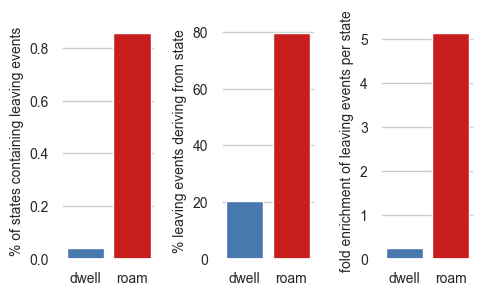

In [125]:
#looking at Roam/Dwell ~ Lawn Exit overlap - these need confidence intervals
fig,axs = plt.subplots(1,3,figsize=(5,3))

x,y = 'Roam/Dwell states', 'lawn exit'
tmp = bigDF.groupby(x)[y].value_counts(normalize=True).mul(100).unstack()[1.0].to_frame().rename(columns={1.0 :'frequency'})
tmp.reset_index(level=0, inplace=True)

sns.barplot(data=tmp,x='Roam/Dwell states',y='frequency',palette=colors, ax = axs[0])
axs[0].set_ylabel('% of states containing leaving events')
axs[0].set_xlabel('')

x,y = 'lawn exit','Roam/Dwell states' 
tmp = bigDF.groupby(x)[y].value_counts(normalize=True).mul(100).unstack(0)[1.0].to_frame().rename(columns={1.0 :'frequency'})
tmp.reset_index(level=0, inplace=True)

sns.barplot(data=tmp,x='Roam/Dwell states',y='frequency',palette=colors, ax = axs[1])
axs[1].set_ylabel('% leaving events deriving from state')
axs[1].set_xlabel('')

#show enrichment per state (% lawn exits from state scaled by overall state frequency)
tmp2 = tmp.set_index("Roam/Dwell states")
overallfreq = bigDF['Roam/Dwell states'].value_counts(normalize=True)
freq2 = overallfreq.to_frame().rename(columns={'Roam/Dwell states': 'frequency'})
enrichment = tmp2/(freq2*100)
enrichment.reset_index(level=0, inplace=True)

sns.barplot(data=enrichment,x='Roam/Dwell states',y='frequency',palette=colors, ax = axs[2])
axs[2].set_ylabel('fold enrichment of leaving events per state')
axs[2].set_xlabel('')

if saveFigures:
    outpath = os.path.join(figpath,'FracStateOverlap'+'_RoamDwell_'+'lawnExits_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)


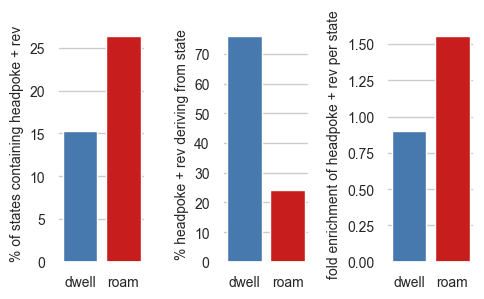

In [126]:
#looking at Roam/Dwell ~ Headpoke+Rev overlap
fig,axs = plt.subplots(1,3,figsize=(5,3))

x,y = 'Roam/Dwell states', 'head poke + rev'
tmp = bigDF.groupby(x)[y].value_counts(normalize=True).mul(100).unstack()[1.0].to_frame().rename(columns={1.0 :'frequency'})
tmp.reset_index(level=0, inplace=True)

sns.barplot(data=tmp,x='Roam/Dwell states',y='frequency',palette=colors, ax = axs[0])
axs[0].set_ylabel('% of states containing headpoke + rev')
axs[0].set_xlabel('')

x,y = 'head poke + rev','Roam/Dwell states' 
tmp = bigDF.groupby(x)[y].value_counts(normalize=True).mul(100).unstack(0)[1.0].to_frame().rename(columns={1.0 :'frequency'})
tmp.reset_index(level=0, inplace=True)

sns.barplot(data=tmp,x='Roam/Dwell states',y='frequency',palette=colors, ax = axs[1])
axs[1].set_ylabel('% headpoke + rev deriving from state')
axs[1].set_xlabel('')

#show enrichment per state (% lawn exits from state scaled by overall state frequency)
tmp2 = tmp.set_index("Roam/Dwell states")
overallfreq = bigDF['Roam/Dwell states'].value_counts(normalize=True)
freq2 = overallfreq.to_frame().rename(columns={'Roam/Dwell states': 'frequency'})
enrichment = tmp2/(freq2*100)
enrichment.reset_index(level=0, inplace=True)

sns.barplot(data=enrichment,x='Roam/Dwell states',y='frequency',palette=colors, ax = axs[2])
axs[2].set_ylabel('fold enrichment of headpoke + rev per state')
axs[2].set_xlabel('')

if saveFigures:
    outpath = os.path.join(figpath,'FracStateOverlap'+'_RoamDwell_'+'HPREV_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)


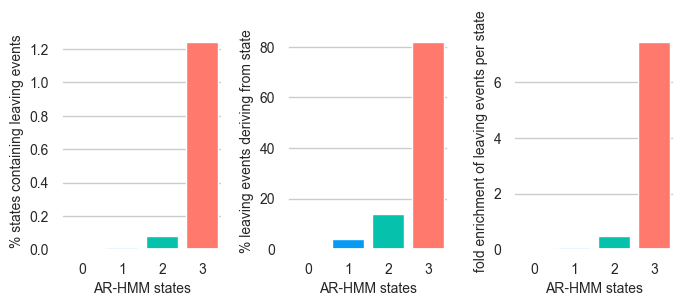

In [127]:
#looking at AR-HMM ~ Lawn Exit overlap
fig,axs = plt.subplots(1,3,figsize=(7,3))
x,y = 'AR-HMM states', 'lawn exit'
tmp = bigDF.groupby(x)[y].value_counts(normalize=True).mul(100).unstack()[1.0].to_frame().rename(columns={1.0 :'frequency'})
tmp.reset_index(level=0, inplace=True)

sns.barplot(data=tmp,x='AR-HMM states',y='frequency',palette=arhmm_colors, saturation=1, ax = axs[0])
axs[0].set_ylabel('% states containing leaving events')
# axs[0].set_xlabel('')

x,y = 'lawn exit','AR-HMM states' 
tmp = bigDF.groupby(x)[y].value_counts(normalize=True).mul(100).unstack(0)[1.0].to_frame().rename(columns={1.0 :'frequency'})
tmp.reset_index(level=0, inplace=True)

sns.barplot(data=tmp,x='AR-HMM states',y='frequency',palette=arhmm_colors, saturation=1,ax = axs[1])
axs[1].set_ylabel('% leaving events deriving from state')
# axs[1].set_xlabel('')

#show enrichment per state (% lawn exits from state scaled by overall state frequency)
tmp2 = tmp.set_index("AR-HMM states")
overallfreq = bigDF['AR-HMM states'].value_counts(normalize=True).sort_index()
freq2 = overallfreq.to_frame().rename(columns={'AR-HMM states': 'frequency'})
enrichment = tmp2/(freq2*100)
enrichment.reset_index(level=0, inplace=True)

sns.barplot(data=enrichment,x='AR-HMM states',y='frequency',palette=arhmm_colors, saturation=1,ax = axs[2])
axs[2].set_ylabel('fold enrichment of leaving events per state')
# axs[2].set_xlabel('')

if saveFigures:
    outpath = os.path.join(figpath,'FracStateOverlap'+'arHMM_lawnExits_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)


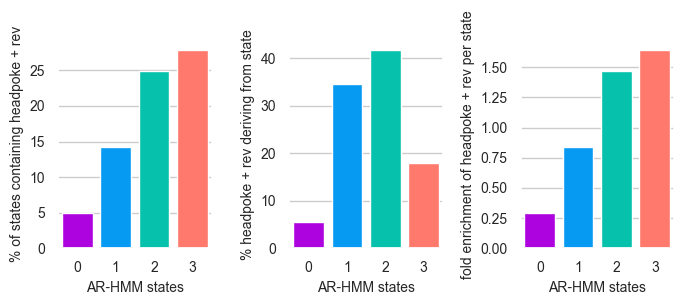

In [128]:
#looking at AR-HMM ~ Headpoke+Rev overlap
fig,axs = plt.subplots(1,3,figsize=(7,3))

x,y = 'AR-HMM states', 'head poke + rev'
tmp = bigDF.groupby(x)[y].value_counts(normalize=True).mul(100).unstack()[1.0].to_frame().rename(columns={1.0 :'frequency'})
tmp.reset_index(level=0, inplace=True)

sns.barplot(data=tmp,x='AR-HMM states',y='frequency',palette=arhmm_colors, saturation=1,ax = axs[0])
axs[0].set_ylabel('% of states containing headpoke + rev')


x,y = 'head poke + rev','AR-HMM states' 
tmp = bigDF.groupby(x)[y].value_counts(normalize=True).mul(100).unstack(0)[1.0].to_frame().rename(columns={1.0 :'frequency'})
tmp.reset_index(level=0, inplace=True)

sns.barplot(data=tmp,x='AR-HMM states',y='frequency',palette=arhmm_colors, saturation=1,ax = axs[1])
axs[1].set_ylabel('% headpoke + rev deriving from state')

#show enrichment per state (% lawn exits from state scaled by overall state frequency)
tmp2 = tmp.set_index("AR-HMM states")
overallfreq = bigDF['AR-HMM states'].value_counts(normalize=True).sort_index()
freq2 = overallfreq.to_frame().rename(columns={'AR-HMM states': 'frequency'})
enrichment = tmp2/(freq2*100)
enrichment.reset_index(level=0, inplace=True)

sns.barplot(data=enrichment,x='AR-HMM states',y='frequency',palette=arhmm_colors, saturation=1,ax = axs[2])
axs[2].set_ylabel('fold enrichment of headpoke + rev per state')

if saveFigures:
    outpath = os.path.join(figpath,'FracStateOverlap'+'arHMM_headPokeReversals_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)


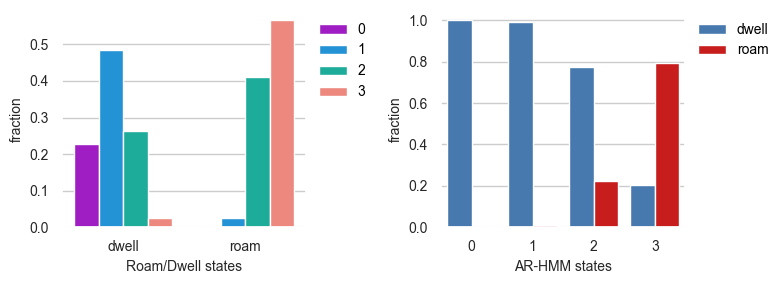

In [129]:
#plot state overlap between AR-HMM and R/D states
fig,axs = plt.subplots(1,2,figsize=(8,3))
x,y = 'Roam/Dwell states', 'AR-HMM states'

(bigDF
.groupby(x)[y]
.value_counts(normalize=True)
.rename('fraction')
.reset_index()
.pipe((sns.barplot,'data'), x=x,y='fraction',hue=y,palette=arhmm_colors, ax = axs[0]))
axs[0].legend(bbox_to_anchor=(1, 1),loc="upper left",frameon=False)

x,y = 'AR-HMM states','Roam/Dwell states'
(bigDF
.groupby(x)[y]
.value_counts(normalize=True)
.rename('fraction')
.reset_index()
.pipe((sns.barplot,'data'), x=x,y='fraction',hue=y,palette=colors, ax = axs[1]))
axs[1].legend(bbox_to_anchor=(1, 1),loc="upper left",frameon=False)
if saveFigures:
    outpath = os.path.join(figpath,'FracStateOverlap'+'_RoamDwell''_kappa_'+str(arHMM_model.transitions.kappa)+'_numstates_'+str(arHMM_model.K)+'_'+datestring+'.pdf')
    plt.savefig(outpath)#,dpi=300)

### Compare small lawns and uniform lawns

In [130]:
#Choose genotype comparison:

from datetime import date, datetime, timedelta

keysToExtract = ['missingdata',\
                 'bin_LawnExit_mostRecent','bin_HeadPokeFwd', 'bin_HeadPokeRev', 'bin_HeadPokePause', 'bin_HeadPokesAll',\
                 'Centroid_x', 'Centroid_y', 'Centroid_speed', 'Centroid_angspeed',\
                 'Midbody_speed','Midbody_angspeed','Lawn_Boundary_Dist','Centroid_grayscale','Head_grayscale','Head_norm_grayscale','Bacterial_Density','Centroid_Bacterial_Density',\
                 'Quirkiness','bin_Quirkiness_inLawn',\
                 'bin_Head_speed','bin_Midbody_absSpeed','bin_Midbody_fspeed',\
                 'bin_Midbody_rspeed','bin_Midbody_angspeed','bin_Bacterial_Density','bin_Centroid_Bacterial_Density',\
                 'bin_MovingForward','bin_MovingReverse','bin_Pause',\
                 'binMissing_spline','binMissing_centroid','InLawnRunMask','InLawnRunMask_centroid',\
                 'bin_Head_speed_inLawn','bin_Midbody_absSpeed_inLawn','bin_Midbody_fspeed_inLawn','bin_Midbody_rspeed_inLawn',\
                 'bin_Midbody_fspeed_adj_inLawn',
                 'bin_Centroid_speed_inLawn', 'bin_Centroid_angspeed_inLawn',\
                 'bin_Bacterial_Density_inLawn','bin_Centroid_Bacterial_Density_inLawn','bin_Head_norm_grayscale_inLawn','bin_MovingForward_inLawn','bin_MovingReverse_inLawn','bin_Pause_inLawn',\
                 'bin_Lawn_Boundary_Dist_inLawn','bin_Head_angspeed_inLawn','bin_Midbody_angspeed_inLawn',\
                 'RD_states_Matrix_exog','RD_states_Matrix_exog_Cent','arHMM_MLstates']


dataType = 'od2_UL_LL'

Datas = [augmentULdata(OtherDensity['PD1074_od2_uniformlawn_Data']),wildtype['PD1074_od2_Data']]
genotypes = ['uniform lawn','small lawn']
pairs = [(genotypes[0],genotypes[1])]

forbiddenDates = []
# these ones are always forbidden
forbiddenDates.append(date(2021,5,17))
forbiddenDates.append(date(2021,6,14))
#others
# forbiddenDates.append(date(2022,3,11))
# forbiddenDates.append(date(2021,8,5))
# forbiddenDates.append(date(2021,8,13))

datesToInclude = []
subset = 100
Data_subs, Data_comparison_dfs = compareGenotypes(Datas,genotypes,keysToExtract,binSize, 4, 2, forbiddenDates, datesToInclude, subset=subset)

Comparisons_df = generateComparisonsDF(Data_comparison_dfs)
df_containsLL = getPropLawnLeaving(Comparisons_df,"genotype")

#set parameters for aligning things
framesPerMin = 6
numMins = 5
binTimeBefore = numMins*framesPerMin
binTimeAfter = binTimeBefore

#define color scheme

color_names = [
    "grey",
    "blue",
    "orange"
    ]


colors_up_or_down = sns.xkcd_palette(color_names)
# genotype_colors = default_colors
genotype_colors = colors_up_or_down

#define figure size
figsize = (2.5,4)

#make a subfolder to save these figures
separator = ','
genNames = separator.join(genotypes)
folderName = genNames+' '+dataType
subfolder = os.path.join(figpath,folderName)
if subset is not None:
    subfolder = subfolder+"_subset"+str(subset)
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

saveFigures = True

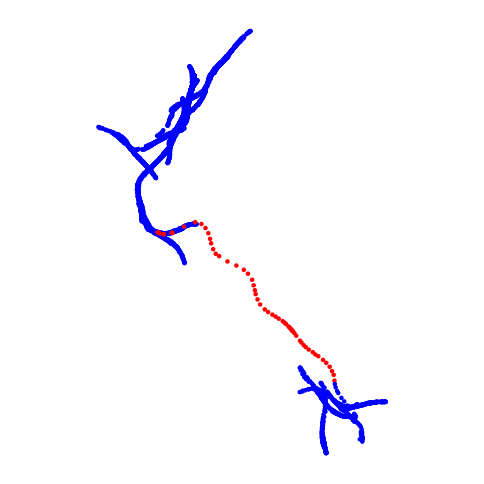

In [131]:
#make a plot of roaming and dwelling for a uniform lawn animal
import matplotlib
rd_cmap = matplotlib.colors.ListedColormap(['blue','red'])

data = OtherDensity['N2_od5_uniformlawn_Data'] #4
# data = OtherDensity['PD1074_od2_UL_Data'] #4
# data = OtherDensity['PD1074_DandN_Data']
idx = 4

x_pos = data['Midbody_cent_x'][idx]
y_pos = data['Midbody_cent_y'][idx]
RD = np.repeat(data['RD_states_Matrix_exog_Cent'][idx].astype(int),binSize)

fig,axs = plt.subplots(1,1,figsize=(5,5))
axs.grid(b=None)
axs.scatter(x_pos,y_pos,5,RD,cmap=rd_cmap)
axs.axis('equal')
axs.set_xticks([])
axs.set_yticks([])

if saveFigures:
    outpath = os.path.join(subfolder,'RoamingDwelling_ExampleTrajectory'+'_'+datestring)
    plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')

In [132]:
#number of worms per genotype
Data_comparison_dfs['missingdata']['genotype'].value_counts()

small lawn      31
uniform lawn    31
Name: genotype, dtype: int64

<ipython-input-133-dc460b884973>:17: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.gcf().canvas.draw()
<ipython-input-133-dc460b884973>:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.savefig(outpath,bbox_inches=nbbox,dpi=300)
/Users/eliasscheer/PycharmProjects/lawnleaving_venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


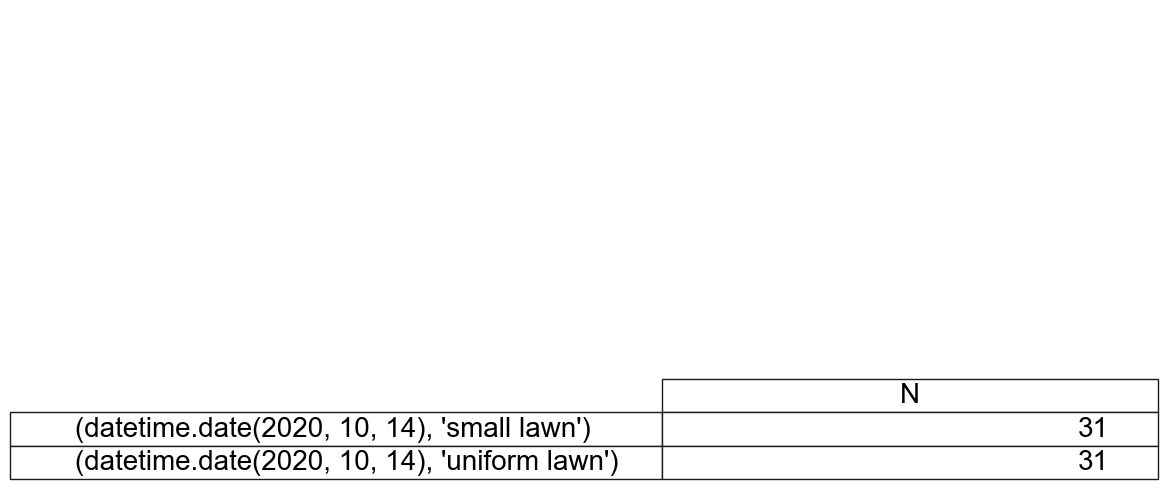

In [133]:
#plot a summary table showing N by date
import matplotlib.pyplot as plt
from pandas.plotting import table 

df_summary = Data_comparison_dfs['missingdata'].rename(columns={"matfilename":"N"}).groupby(["dates","genotype"]).count()['N']

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

ytable = table(ax, df_summary,fontsize=14)
ytable.set_fontsize(20)
ytable.scale(1, 2)

#prepare for saving:
# draw canvas once
plt.gcf().canvas.draw()
# get bounding box of table
points = ytable.get_window_extent(plt.gcf()._cachedRenderer).get_points()
# add 10 pixel spacing
points[0,:] -= 10; points[1,:] += 10
# get new bounding box in inches
nbbox = mpl.transforms.Bbox.from_extents(points/plt.gcf().dpi)

if saveFigures:
    if len(genNames)<100:
        outpath = os.path.join(subfolder,genNames+'_Data_N_summary'+'_'+datestring+'.png')
    else:
        outpath = os.path.join(subfolder,'Data_N_summary'+'_'+datestring+'.png')
    plt.savefig(outpath,bbox_inches=nbbox,dpi=300)

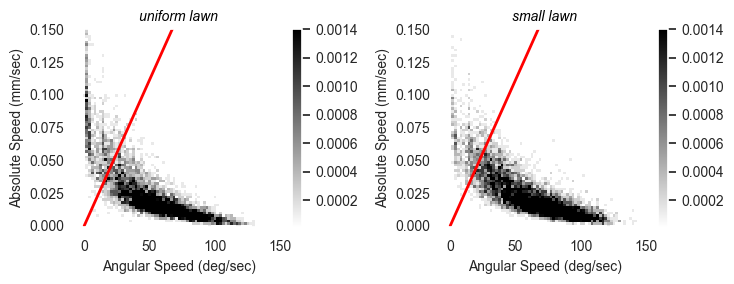

In [134]:
# 2D Histograms of Roaming/Dwelling for Uniform versus Small Lawns

fig,axs = plt.subplots(1,2,figsize=(7.5,3))
decision_slope = 450
x_offset = 0
numBins = 75

norm = mpl.colors.Normalize(vmin=1e-5,vmax=1.4e-3)
# norm = mpl.colors.LogNorm(vmin=1e-4,vmax=1e-2,clip=True)
# norm = mpl.colors.SymLogNorm(linthresh=1e-7, linscale=1, vmin=1e-5, vmax=5e-3)
    
for i, Data in enumerate(Data_subs.values()):
    dataFrac = 1
    numToChoose = np.round(Data['bin_Centroid_angspeed_inLawn'].size*dataFrac).astype(int)
    randIdx = npr.choice(np.arange(Data['bin_Centroid_angspeed_inLawn'].size),numToChoose,replace=False)
    # randIdx = npr.choice(np.arange(Data['bin_Centroid_angspeed_inLawn'].size),int(Data['bin_Centroid_angspeed_inLawn'].size),replace=False)

    plot2dhistosPC1vPC2(axs[i],
                              norm,
                              '',
                              Data['bin_Centroid_angspeed_inLawn'].ravel()[randIdx],
                              'Angular Speed (deg/sec)',
                              np.linspace(-5,150,numBins),
                              Data['bin_Centroid_speed_inLawn'].ravel()[randIdx],
                              'Absolute Speed (mm/sec)',
                              np.linspace(-0.001,0.15,numBins),
                              plt.get_cmap('binary'))

    axs[i].plot(np.linspace(0,150,numBins),(np.linspace(0,150,numBins)-x_offset)/decision_slope,color='red',lw=2)
    axs[i].set_title(genotypes[i],fontstyle='italic')


if saveFigures:
    outpath = os.path.join(subfolder,'RoamingDwellingDecisionBoundary_Centroid'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')
    
    

In [135]:
Comparisons_df.groupby("genotype")['fraction roaming'].agg("mean")

genotype
small lawn      0.146963
uniform lawn    0.241820
Name: fraction roaming, dtype: float64

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uniform lawn vs. small lawn: Custom statistical test, P_val:3.008e-01


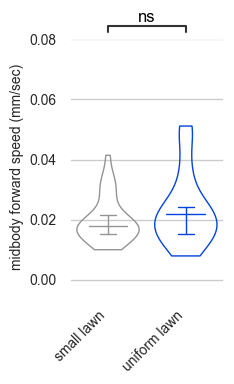

In [136]:
# MIDBODY FORWARD SPEED (Kruskal-Wallis with Dunn's posthoc)
from statannotations.Annotator import Annotator
import scikit_posthocs as sp

rot = 45
plotVar = 'midbody forward speed'
#calculate pvalues using Dunn's posthoc test
pval_adj = sp.posthoc_dunn(Comparisons_df, val_col = plotVar, group_col = "genotype", p_adjust = 'bonferroni')
pvalsToShowInOrder = []
for p in pairs:
    pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])

fig,axs = plt.subplots(1,1,figsize=figsize)
# g = sns.stripplot(data=Comparisons_df,x="genotype",y=plotVar,jitter=True,dodge=True, linewidth=1,palette = genotype_colors, size=3,ax = axs)
# g = sns.boxplot(data=Comparisons_df,x="genotype",y=plotVar,showfliers=False,ax=g,palette = genotype_colors, saturation = 1)
xvar = 'genotype'
df = Comparisons_df[[xvar,plotVar]].reset_index(drop=True).pivot(columns=xvar,values=plotVar)
g = customViolinBoxPlot(df,genotype_colors,axs)
g.set_xticklabels(g.get_xticklabels(), rotation=rot,ha='right')

g.set_ylim([-0.005,0.08])
g.set_ylabel('midbody forward speed (mm/sec)')
plt.locator_params(nbins=6)


g.set_xlabel('')
annotator = Annotator(g, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside')
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()

if saveFigures:
    outpath = os.path.join(subfolder,'MidbodyForwardSpeed'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uniform lawn vs. small lawn: Custom statistical test, P_val:2.133e-02


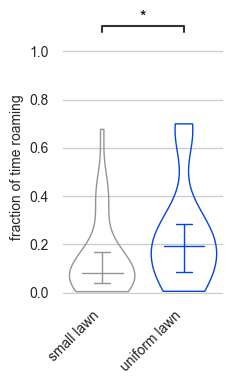

In [137]:
#FRACTION ROAMING (Kruskal-Wallis with Dunn's posthoc)
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator

plotVar = 'fraction roaming'
#calculate pvalues using Dunn's posthoc test
pval_adj = sp.posthoc_dunn(Comparisons_df, val_col = plotVar, group_col = "genotype", p_adjust = 'bonferroni')
pvalsToShowInOrder = []
for p in pairs:
    pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])


fig,axs = plt.subplots(1,1,figsize=figsize)
# g = sns.stripplot(data=Comparisons_df,x="genotype",y=plotVar,jitter=True,dodge=True, linewidth=1,palette = genotype_colors, size=3,ax = axs)
# g = sns.boxplot(data=Comparisons_df,x="genotype",y=plotVar,showfliers=False,ax=g,palette = genotype_colors, saturation = 1)

xvar = 'genotype'
df = Comparisons_df[[xvar,plotVar]].reset_index(drop=True).pivot(columns=xvar,values=plotVar)
g = customViolinBoxPlot(df,genotype_colors,axs)
g.set_xticklabels(g.get_xticklabels(), rotation=rot,ha='right')
# g.set_ylim([-0.05,1.05])
g.set_ylim([-0.01,1.05])
g.set_ylabel('fraction of time roaming')
plt.locator_params(nbins=6)

# for patch in g.artists:
#     rc, gc, bc, a = patch.get_facecolor()
#     patch.set_facecolor((rc, gc, bc, .6))

g.set_xlabel('')
annotator = Annotator(g, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside')
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()

if saveFigures:
    outpath = os.path.join(subfolder,'FractionRoaming'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uniform lawn vs. small lawn: Custom statistical test, P_val:1.499e-03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uniform lawn vs. small lawn: Custom statistical test, P_val:1.245e-02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uniform lawn vs. small lawn: Custom statistical test, P_val:7.621e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

uniform lawn vs. small lawn: Custom statistical test, P_val:2.771e

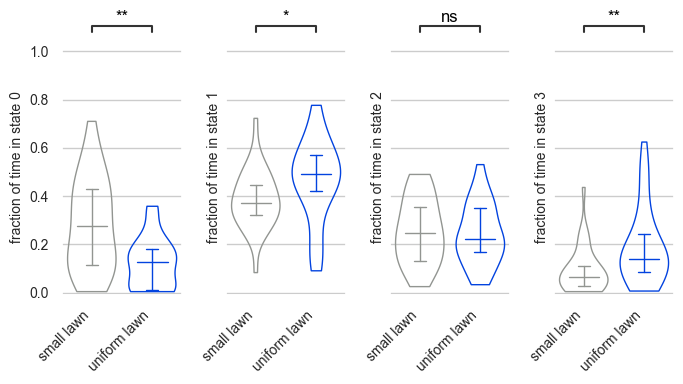

In [138]:
#FRACTION AR-HMM States (Kruskal-Wallis with Dunn's posthoc)
import matplotlib.patches as mpatches
from scipy.stats import mannwhitneyu, normaltest
from statannotations.Annotator import Annotator

fig,axs = plt.subplots(1,4,figsize=(7,4),sharey=True,tight_layout=True)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plotVar = 'fraction state 0'
#calculate pvalues using Dunn's posthoc test
pval_adj = sp.posthoc_dunn(Comparisons_df, val_col = plotVar, group_col = "genotype", p_adjust = 'bonferroni')
pvalsToShowInOrder = []
for p in pairs:
    pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])

# g = sns.stripplot(data=Comparisons_df,x="genotype",y=plotVar,jitter=True,dodge=True, linewidth=1,palette = genotype_colors, size=3,ax = axs[0])
# g = sns.boxplot(data=Comparisons_df,x="genotype",y=plotVar,showfliers=False,ax=g,palette = genotype_colors, saturation = 1)
xvar = 'genotype'
df = Comparisons_df[[xvar,plotVar]].reset_index(drop=True).pivot(columns=xvar,values=plotVar)
g = customViolinBoxPlot(df,genotype_colors,axs[0])
g.set_xticklabels(g.get_xticklabels(), rotation=rot,ha='right')
g.set_ylim([-0.01,1.05])

g.set_ylabel('fraction of time in state 0')
# g.set_title('state 0')
# plt.locator_params(nbins=6)

# for patch in g.artists:
#     rc, gc, bc, a = patch.get_facecolor()
#     patch.set_facecolor((rc, gc, bc, .6))
    
g.set_xlabel('')
annotator = Annotator(g, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside')
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plotVar = 'fraction state 1'
#calculate pvalues using Dunn's posthoc test
pval_adj = sp.posthoc_dunn(Comparisons_df, val_col = plotVar, group_col = "genotype", p_adjust = 'bonferroni')
pvalsToShowInOrder = []
for p in pairs:
    pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])

# g = sns.stripplot(data=Comparisons_df,x="genotype",y=plotVar,jitter=True,dodge=True, linewidth=1,palette = genotype_colors, size=3,ax = axs[1])
# g = sns.boxplot(data=Comparisons_df,x="genotype",y=plotVar,showfliers=False,ax=g,palette = genotype_colors, saturation = 1)
xvar = 'genotype'
df = Comparisons_df[[xvar,plotVar]].reset_index(drop=True).pivot(columns=xvar,values=plotVar)
g = customViolinBoxPlot(df,genotype_colors,axs[1])
g.set_xticklabels(g.get_xticklabels(), rotation=rot,ha='right')
g.set_ylim([-0.01,1.05])
g.set_ylabel('fraction of time in state 1')
# g.set_title('state 1')
# plt.locator_params(nbins=6)

# for patch in g.artists:
#     rc, gc, bc, a = patch.get_facecolor()
#     patch.set_facecolor((rc, gc, bc, .6))
    
g.set_xlabel('')
annotator = Annotator(g, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside')
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plotVar = 'fraction state 2'
#calculate pvalues using Dunn's posthoc test
pval_adj = sp.posthoc_dunn(Comparisons_df, val_col = plotVar, group_col = "genotype", p_adjust = 'bonferroni')
pvalsToShowInOrder = []
for p in pairs:
    pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])

# g = sns.stripplot(data=Comparisons_df,x="genotype",y=plotVar,jitter=True,dodge=True, linewidth=1,palette = genotype_colors, size=3,ax = axs[2])
# g = sns.boxplot(data=Comparisons_df,x="genotype",y=plotVar,showfliers=False,ax=g,palette = genotype_colors, saturation = 1)

xvar = 'genotype'
df = Comparisons_df[[xvar,plotVar]].reset_index(drop=True).pivot(columns=xvar,values=plotVar)
g = customViolinBoxPlot(df,genotype_colors,axs[2])
g.set_xticklabels(g.get_xticklabels(), rotation=rot,ha='right')
g.set_ylim([-0.01,1.05])

g.set_ylabel('fraction of time in state 2')

# g.set_title('state 2')
# plt.locator_params(nbins=6)
# for patch in g.artists:
#     rc, gc, bc, a = patch.get_facecolor()
#     patch.set_facecolor((rc, gc, bc, .6))
    
g.set_xlabel('')
annotator = Annotator(g, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside')
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plotVar = 'fraction state 3'
#calculate pvalues using Dunn's posthoc test
pval_adj = sp.posthoc_dunn(Comparisons_df, val_col = plotVar, group_col = "genotype", p_adjust = 'bonferroni')
pvalsToShowInOrder = []
for p in pairs:
    pvalsToShowInOrder.append(pval_adj.loc[p[0]].loc[p[1]])

# g = sns.stripplot(data=Comparisons_df,x="genotype",y=plotVar,jitter=True,dodge=True, linewidth=1,palette = genotype_colors, size=3,ax = axs[3])
# g = sns.boxplot(data=Comparisons_df,x="genotype",y=plotVar,showfliers=False,ax=g,palette = genotype_colors, saturation = 1)
xvar = 'genotype'
df = Comparisons_df[[xvar,plotVar]].reset_index(drop=True).pivot(columns=xvar,values=plotVar)
g = customViolinBoxPlot(df,genotype_colors,axs[3])
g.set_xticklabels(g.get_xticklabels(), rotation=rot,ha='right')
g.set_ylim([-0.01,1.05])
g.set_ylabel('fraction of time in state 3')
# g.set_title('state 3')
# plt.locator_params(nbins=6)

# for patch in g.artists:
#     rc, gc, bc, a = patch.get_facecolor()
#     patch.set_facecolor((rc, gc, bc, .6))
    
g.set_xlabel('')
annotator = Annotator(g, 
                      pairs, 
                      data=Comparisons_df, 
                      x="genotype",
                      y=plotVar,
                      order=df_containsLL.genotype)
annotator.configure(text_format='star', loc='outside')
annotator.set_pvalues(pvalsToShowInOrder)
_ = annotator.annotate()

if saveFigures:
    outpath = os.path.join(subfolder,'ARHMM_FractionStates'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')


0.1978635222436872
0.05184662071850941


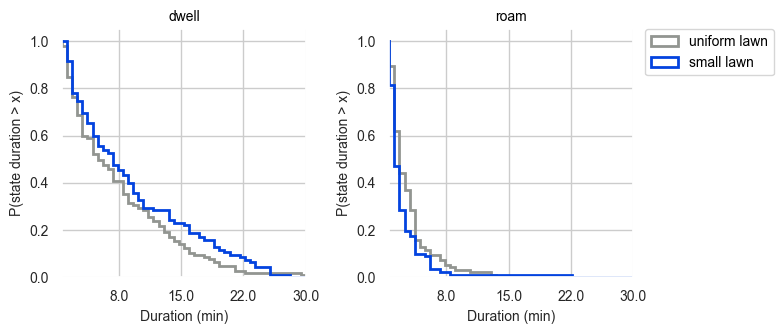

In [139]:
#roam/dwell durations (not significantly different)
import scipy.stats as stats

dates = Data_comparison_dfs['RD_states_Matrix_exog_Cent'].sort_values(by="dates")['dates'].unique()
RDlabels = ['dwell','roam']

durBins = np.linspace(0,30*6,50)
ticklabels=np.round((10/60*np.linspace(0,durBins[-1],5))).astype(str)

#compute overall per genotype        
RD_state_Dur_overall = dict()
for genotype, gen_group in Data_comparison_dfs['RD_states_Matrix_exog_Cent'].groupby("genotype"):
    RD_state_Dur_overall[genotype] = computeStateDurations(gen_group.loc[:,0:239].fillna(2).to_numpy().astype(int))

ULvLL_DwellDur_stat,ULvLL_DwellDur_pval = stats.ks_2samp(RD_state_Dur_overall[genotypes[1]][0], RD_state_Dur_overall[genotypes[0]][0])
print(ULvLL_DwellDur_pval)
ULvLL_RoamDur_stat,ULvLL_RoamDur_pval = stats.ks_2samp(RD_state_Dur_overall[genotypes[1]][1], RD_state_Dur_overall[genotypes[0]][1])
print(ULvLL_RoamDur_pval)

# plot states separately  
fig,axs = plt.subplots(1, 2, sharey=False, sharex=False, tight_layout=True, figsize=(8,3.5))
for k in range(0,2): #over states
    #plot overall
    for i, genotype in enumerate(genotypes):
        axs[k].hist(RD_state_Dur_overall[genotype][k],bins=durBins,color=genotype_colors[i],density=True,linestyle='solid',alpha=1,histtype='step',cumulative=-1,lw=2,label=genotype)

    axs[k].set_xticks(ticks=np.linspace(0,durBins[-1],5))
    axs[k].set_xticklabels(ticklabels)
    axs[k].set_xlim([durBins[1],durBins[-1]])
    axs[k].set_xlabel('Duration (min)')
    axs[k].set_ylabel('P(state duration > x)')
    if k==len(RDlabels)-1:
        handles, labels = axs[k].get_legend_handles_labels()
        axs[k].legend(handles[-len(genotypes):], labels[-len(genotypes):], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axs[k].set_title(RDlabels[k])


if saveFigures:
    outpath = os.path.join(subfolder,'ULvLL_RoamDwellDuration'+'_'+datestring)
#     plt.savefig(outpath+'.png',dpi=300)
    plt.savefig(outpath+'.pdf')


### Linear Models for Predicting Lawn Leaving


In [140]:
Data = wildtype['PD1074_od2_Data']
genotypes = 'wild type'

In [141]:
#Gather parameters In Lawns

#stricter thresholds for training Data
InLawnMinRunLen = 4*6  # in 10 sec bins *4 minutes in lawn*
OutLawnMinRunLen = 5
InLawnNanThresh = 0.0  # for training only permit intervals with no missing Data -- maybe we can be more permissive on decoding.
OutLawnNanThresh = 0.1
NaNInterpThresh = 3
strictBool = True
###################################

varLabel = "PD1074"

InLawnRunMask, _ = collectOnandOffLawnIntervals_decode(Data['bin_In_Or_Out'],\
                                                       Data['binMissing_centroid'],
                                                       strictBool,\
                                                       InLawnMinRunLen,\
                                                       OutLawnMinRunLen, NaNInterpThresh)

inlawnrunmask = ~InLawnRunMask #True means NOT in lawn
#remove any entries that are entirely NaNs
toKeepIdx = ~np.array([inlawnrunmask[i].all() for i in range(inlawnrunmask.shape[0])])
inlawnrunmask = inlawnrunmask[toKeepIdx] #subselect good indices

#Locomotion parameters
binFracFwd = interpDataInLawn(Data['bin_MovingForward'][toKeepIdx], ~inlawnrunmask)#True means IN LAWN
binMidbodyFspeed = interpDataInLawn(Data['bin_Midbody_fspeed'][toKeepIdx], ~inlawnrunmask)#True means IN LAWN
binMidbodyRspeed = -1*interpDataInLawn(Data['bin_Midbody_rspeed'][toKeepIdx], ~inlawnrunmask)#True means IN LAWN
binMidbodyangspeed = interpDataInLawn(Data['bin_Midbody_angspeed'][toKeepIdx], ~inlawnrunmask)
binHeadspeed = interpDataInLawn(Data['bin_Head_speed'][toKeepIdx], ~inlawnrunmask)
binHeadangspeed = interpDataInLawn(Data['bin_Head_angspeed'][toKeepIdx], ~inlawnrunmask)
binHeadAngVelrelMid = interpDataInLawn(Data['bin_headAngVel_relMid'][toKeepIdx], ~inlawnrunmask)
binHeadRadVelrelMid = interpDataInLawn(Data['bin_headRadVel_relMid'][toKeepIdx], ~inlawnrunmask)
binQuirkiness = interpDataInLawn(Data['bin_Quirkiness'][toKeepIdx], ~inlawnrunmask)

#Lawn parameters
binRadTrajAngle = interpDataInLawn(Data['bin_radTrajAngle'][toKeepIdx], ~inlawnrunmask)
binHeadGrayscale = interpDataInLawn(zscore(Data['bin_Head_grayscale'][toKeepIdx],axis=1,nan_policy='omit'), ~inlawnrunmask)
binBacterialDensity = interpDataInLawn(Data['bin_Bacterial_Density'][toKeepIdx], ~inlawnrunmask)
binLawnBoundaryDist = interpDataInLawn(Data['bin_Lawn_Boundary_Dist'][toKeepIdx], ~inlawnrunmask)
binLawnExit_tmp = np.ma.masked_array(Data['bin_LawnExit_mostRecent'][toKeepIdx], mask=inlawnrunmask)
binLawnExit = findMostRecentInLawnforLL(binLawnExit_tmp>0,3,inlawnrunmask)
binHPREV = np.ma.masked_array(Data['bin_HeadPokeRev'][toKeepIdx]>0, mask=inlawnrunmask) #binarize -- does bin contain a HP?
#remove HP bins that overlap with LL
binHPREV[binLawnExit.astype(bool)]=False
#make a composite "choice vector": 0 = nothing, 1 = HP+REV, 2 = LL
binChoice = np.zeros_like(binLawnExit,dtype=int)
binChoice[binHPREV.data==True]=1
binChoice[binLawnExit.data==True]=2
binChoice = binChoice.filled(0)

#Split into InLawnRuns (so that there is no missing Data)

#keep track of the original indices of in lawn runs
rowIdx = np.tile(np.arange(0,binMidbodyFspeed.shape[0]).reshape(-1,1),(1,240))
timeIdx = np.tile(np.arange(0,240),(binMidbodyFspeed.shape[0],1))
rowIdx_InLawnRuns = splitIntoInLawnIntervals(rowIdx,inlawnrunmask,True)
timeIdx_InLawnRuns = splitIntoInLawnIntervals(timeIdx,inlawnrunmask,True)

binFracFwd_InLawnRuns = splitIntoInLawnIntervals(binFracFwd,inlawnrunmask,True)
binMidbodyFspeed_InLawnRuns = splitIntoInLawnIntervals(binMidbodyFspeed,inlawnrunmask,True)
binMidbodyRspeed_InLawnRuns = splitIntoInLawnIntervals(binMidbodyRspeed,inlawnrunmask,True)
binMidbodyangspeed_InLawnRuns = splitIntoInLawnIntervals(binMidbodyangspeed,inlawnrunmask,True)
binHeadspeed_InLawnRuns = splitIntoInLawnIntervals(binHeadspeed,inlawnrunmask,True)
binHeadangspeed_InLawnRuns = splitIntoInLawnIntervals(binHeadangspeed,inlawnrunmask,True)
binHeadAngVelrelMid_InLawnRuns = splitIntoInLawnIntervals(binHeadAngVelrelMid,inlawnrunmask,True)
binHeadRadVelrelMid_InLawnRuns = splitIntoInLawnIntervals(binHeadRadVelrelMid,inlawnrunmask,True)
binQuirkiness_InLawnRuns = splitIntoInLawnIntervals(binQuirkiness,inlawnrunmask,True)

binRadTrajAngle_InLawnRuns = splitIntoInLawnIntervals(binRadTrajAngle,inlawnrunmask,True)
binHeadGrayscale_InLawnRuns = splitIntoInLawnIntervals(binHeadGrayscale,inlawnrunmask,True)
binBacterialDensity_InLawnRuns = splitIntoInLawnIntervals(binBacterialDensity,inlawnrunmask,True)
binLawnBoundaryDist_InLawnRuns = splitIntoInLawnIntervals(binLawnBoundaryDist,inlawnrunmask,True)
binLawnExit_InLawnRuns = splitIntoInLawnIntervals(binLawnExit,inlawnrunmask,True)
binHPREV_InLawnRuns = splitIntoInLawnIntervals(binHPREV,inlawnrunmask,True)
binChoice_InLawnRuns = splitIntoInLawnIntervals(binChoice,inlawnrunmask,True)

RDstates_InLawnRuns = splitIntoInLawnIntervals(Data['RD_states_Matrix_exog_Cent'],inlawnrunmask,True)
MLstates_InLawnRuns = splitIntoInLawnIntervals(Data['arHMM_MLstates'],inlawnrunmask,True)

#is there any added benefit of combining these states?
Roam_and_State3 = np.logical_and(Data['RD_states_Matrix_exog_Cent'],Data['arHMM_MLstates']==3.0)
Roam_and_State3_InLawnRuns = splitIntoInLawnIntervals(Roam_and_State3,inlawnrunmask,True)

In [142]:
folderName = 'GLMstuff'
subfolder = os.path.join(figpath,folderName)
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

In [143]:
#make Obs train and test for Probit Model with HMM features

from sklearn.model_selection import train_test_split
testSize = 0.33

Obs_forGLM = [np.hstack([binMidbodyFspeed_InLawnRuns[i].reshape(-1,1),\
                         binMidbodyRspeed_InLawnRuns[i].reshape(-1,1),\
                         binMidbodyangspeed_InLawnRuns[i].reshape(-1,1),\
                         binHeadspeed_InLawnRuns[i].reshape(-1,1),\
                         binHeadangspeed_InLawnRuns[i].reshape(-1,1),\
                         binHeadAngVelrelMid_InLawnRuns[i].reshape(-1,1),\
                         binHeadRadVelrelMid_InLawnRuns[i].reshape(-1,1),\
                         binQuirkiness_InLawnRuns[i].reshape(-1,1),\
                         MLstates_InLawnRuns[i].reshape(-1,1)])
                     for i in range(len(binMidbodyFspeed_InLawnRuns))] #include ones as a bias term
# binBacterialDensity_InLawnRuns[i].reshape(-1,1),\
# binLawnBoundaryDist_InLawnRuns[i].reshape(-1,1),\

# #only the statistically significant terms:
# Obs_forGLM = [np.hstack([binMidbodyFspeed_InLawnRuns[i].reshape(-1,1),\
#                          binHeadAngVelrelMid_InLawnRuns[i].reshape(-1,1),\
#                          MLstates_InLawnRuns[i].reshape(-1,1),\
#                          binLawnBoundaryDist_InLawnRuns[i].reshape(-1,1)])
#                      for i in range(len(binMidbodyFspeed_InLawnRuns))] #include ones as a bias term


binChoice_list = [binChoice_InLawnRuns[i].reshape(-1,1) for i in range(len(binChoice_InLawnRuns))]
binLeaving_list = [binLawnExit_InLawnRuns[i].reshape(-1,1) for i in range(len(binLawnExit_InLawnRuns))]

ind = np.arange(0,len(Obs_forGLM))
Obs_train_forGLM, Obs_test_forGLM, Obs_trainIdx_forGLM, Obs_testIdx_forGLM  = train_test_split(Obs_forGLM, ind, test_size=testSize, random_state=35)

Choice_train_forGLM = list(np.array(binChoice_list,dtype=object)[Obs_trainIdx_forGLM])
Choice_test_forGLM = list(np.array(binChoice_list,dtype=object)[Obs_testIdx_forGLM])

Leaving_train_forGLM = list(np.array(binLeaving_list,dtype=object)[Obs_trainIdx_forGLM])
Leaving_test_forGLM = list(np.array(binLeaving_list,dtype=object)[Obs_testIdx_forGLM])

In [144]:
#1) Logit regression with Bernoulli responses for lawn leaving only + MLstates
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm

# 'bacterial density', 'l.b. dist.'
allObs = pd.DataFrame(np.vstack(Obs_train_forGLM), columns=['midbody f. speed','midbody r. speed','midbody ang. speed','head speed','head ang. speed','head ang. vel','head rad. vel','quirkiness','HMM states'])
# allObs = pd.DataFrame(np.vstack(Obs_train_forGLM), columns=['midbody f. speed','head ang. vel','HMM states','lawn boundary dist.'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
# X = allObs
Y = np.vstack(Leaving_train_forGLM)

model = Logit(Y, X.astype(float))
logit_model = model.fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.008780
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               226051
Model:                          Logit   Df Residuals:                   226041
Method:                           MLE   Df Model:                            9
Date:                Wed, 15 Feb 2023   Pseudo R-squ.:                  0.1495
Time:                        00:09:01   Log-Likelihood:                -1984.7
converged:                       True   LL-Null:                       -2333.5
Covariance Type:            nonrobust   LLR p-value:                2.159e-144
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
bias                  -9.2905      0.669    -13.885      0.000     -10.602      -7.979
midb

In [145]:
x = logit_model.summary().tables[0]
pd.DataFrame(x).to_csv("LogitGLM_0.csv")
x = logit_model.summary().tables[1]
pd.DataFrame(x).to_csv("LogitGLM_1.csv")

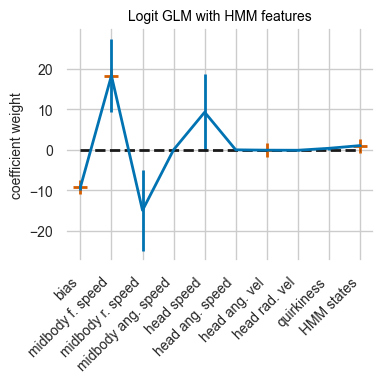

In [146]:
#plot weights - no HISTORY
%matplotlib inline
import matplotlib.pyplot as plt

# _ = plt.plot(logit_model.params)
fig,axs = plt.subplots(1,1,figsize=(4,4))
_ = axs.errorbar(np.arange(len(logit_model.params)), logit_model.params, yerr=logit_model.bse)
sigIdx = logit_model.pvalues<0.05
_ = axs.scatter(np.where(sigIdx)[0],logit_model.params[sigIdx].to_numpy(),marker='+',color='r')
_ = axs.set_xticks(np.arange(len(logit_model.params)))
_ = axs.set_xticklabels(X.columns,rotation = 45,ha='right')
_ = axs.hlines(0,xmin=0,xmax=len(logit_model.params)-1,colors='k',linestyles='--')
_ = axs.set_yticks(np.arange(-20,21,10))
_ = axs.set_ylabel("coefficient weight")
_ = axs.set_title("Logit GLM with HMM features")
outpath = os.path.join(subfolder,varLabel+'GLMlogitwithHMMfeatures_weights'+'_'+datestring+'.pdf')
plt.savefig(outpath)#,dpi=300)



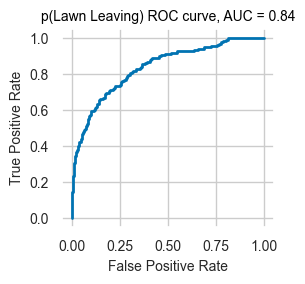

In [147]:
# in order to evaluate the model, examine the predictions on held out data, generate ROC curves - NO HISTORY
from sklearn import metrics
allObs_noHistory_test = pd.DataFrame(np.vstack(Obs_test_forGLM), columns=['midbody f. speed','midbody r. speed','midbody ang. speed','head speed','head ang. speed','head ang. vel','head rad. vel','quirkiness','HMM states'])                                  
# allObs_noHistory_test = pd.DataFrame(np.vstack(Obs_test_forGLM), columns=['midbody f. speed','head ang. vel','HMM states','lawn boundary dist.'])                                  

# allObs_noHistory_test = allObs_noHistory_test.drop(columns="bias") #drop the bias
X_test = sm.add_constant(allObs_noHistory_test) #add back the bias
# X_test = allObs_noHistory_test
Y_test = np.vstack(Leaving_test_forGLM)
                                  
Y_pred = logit_model.predict(X_test)

fpr, tpr, thresholds = metrics.roc_curve(Y_test,Y_pred,pos_label=1)
fig,axs = plt.subplots(1,1,figsize=(3,3))
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("p(Lawn Leaving) ROC curve, AUC = "+str(np.round(metrics.auc(fpr, tpr),2)),fontsize=10)
outpath = os.path.join(subfolder,varLabel+'GLMlogitwithHMMfeatures_ROCcurve'+'_'+datestring+'.pdf')
plt.savefig(outpath)#,dpi=300)

In [148]:
#re-establish the Obs with RD states and AR-HMM states
Obs_forGLM = [np.hstack([binMidbodyFspeed_InLawnRuns[i].reshape(-1,1),\
                         binMidbodyRspeed_InLawnRuns[i].reshape(-1,1),\
                         binMidbodyangspeed_InLawnRuns[i].reshape(-1,1),\
                         binHeadspeed_InLawnRuns[i].reshape(-1,1),\
                         binHeadangspeed_InLawnRuns[i].reshape(-1,1),\
                         binHeadAngVelrelMid_InLawnRuns[i].reshape(-1,1),\
                         binHeadRadVelrelMid_InLawnRuns[i].reshape(-1,1),\
                         binQuirkiness_InLawnRuns[i].reshape(-1,1),\
                         binBacterialDensity_InLawnRuns[i].reshape(-1,1),\
                         binLawnBoundaryDist_InLawnRuns[i].reshape(-1,1),\
                         RDstates_InLawnRuns[i].reshape(-1,1),\
                         MLstates_InLawnRuns[i].reshape(-1,1),\
                         Roam_and_State3_InLawnRuns[i].reshape(-1,1)])\
                     for i in range(len(binMidbodyFspeed_InLawnRuns))] #include ones as a bias term

binLeaving_list = [binLawnExit_InLawnRuns[i].reshape(-1,1) for i in range(len(binLawnExit_InLawnRuns))]

ind = np.arange(0,len(Obs_forGLM))
Obs_train_forGLM, Obs_test_forGLM, Obs_trainIdx_forGLM, Obs_testIdx_forGLM  = train_test_split(Obs_forGLM, ind, test_size=testSize, random_state=35)

Leaving_train_forGLM = list(np.array(binLeaving_list,dtype=object)[Obs_trainIdx_forGLM])
Leaving_test_forGLM = list(np.array(binLeaving_list,dtype=object)[Obs_testIdx_forGLM])

In [149]:
#1) try logit regression with Bernoulli responses for lawn leaving only using each parameter separately
from statsmodels.discrete.discrete_model import Logit
import statsmodels.api as sm

Y = np.vstack(Leaving_train_forGLM)

allObs = pd.DataFrame(np.vstack(Obs_train_forGLM)[:,0], columns=['midbody f. speed'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
model = Logit(Y, X.astype(float))
midbody_fspeed_model = model.fit()

allObs = pd.DataFrame(np.vstack(Obs_train_forGLM)[:,1], columns=['midbody r. speed'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
model = Logit(Y, X.astype(float))
midbody_rspeed_model = model.fit()

allObs = pd.DataFrame(np.vstack(Obs_train_forGLM)[:,2], columns=['midbody ang. speed'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
model = Logit(Y, X.astype(float))
midbody_angspeed_model = model.fit()

allObs = pd.DataFrame(np.vstack(Obs_train_forGLM)[:,3], columns=['head speed'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
model = Logit(Y, X.astype(float))
head_speed_model = model.fit()

allObs = pd.DataFrame(np.vstack(Obs_train_forGLM)[:,4], columns=['head ang. speed'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
model = Logit(Y, X.astype(float))
head_angspeed_model = model.fit()

allObs = pd.DataFrame(np.vstack(Obs_train_forGLM)[:,5], columns=['head ang. vel'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
model = Logit(Y, X.astype(float))
head_angvel_model = model.fit()

allObs = pd.DataFrame(np.vstack(Obs_train_forGLM)[:,6], columns=['head rad. vel'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
model = Logit(Y, X.astype(float))
head_radvel_model = model.fit()

allObs = pd.DataFrame(np.vstack(Obs_train_forGLM)[:,7], columns=['quirkiness'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
model = Logit(Y, X.astype(float))
quirkiness_model = model.fit()

allObs = pd.DataFrame(np.vstack(Obs_train_forGLM)[:,8], columns=['bacterial density'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
model = Logit(Y, X.astype(float))
bacterialdensity_model = model.fit()

allObs = pd.DataFrame(np.vstack(Obs_train_forGLM)[:,9], columns=['l.b. dist.'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
model = Logit(Y, X.astype(float))
lbdist_model = model.fit()

allObs = pd.DataFrame(np.vstack(Obs_train_forGLM)[:,10], columns=['RoamDwell'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
model = Logit(Y, X.astype(float))
roamdwell_model = model.fit()

allObs = pd.DataFrame(np.vstack(Obs_train_forGLM)[:,11], columns=['ARHMM states'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
model = Logit(Y, X.astype(float))
arhmm_model = model.fit()

allObs = pd.DataFrame(np.vstack(Obs_train_forGLM)[:,12], columns=['Roam+State 3'])
X = sm.add_constant(allObs) #add back the bias
X = X.rename(columns={"const": "bias"})
model = Logit(Y, X.astype(float))
roam_and_state3_model = model.fit()

singleParam_GLMs_logit = [midbody_fspeed_model, midbody_rspeed_model, midbody_angspeed_model,\
                    head_speed_model, head_angspeed_model, head_angvel_model,\
                   head_radvel_model, quirkiness_model, bacterialdensity_model,\
                    lbdist_model, roamdwell_model, arhmm_model,roam_and_state3_model]

# print(midbody_fspeed_model.summary())

Optimization terminated successfully.
         Current function value: 0.009112
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010281
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009224
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.009093
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009305
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.009919
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010140
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010320
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010320
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.

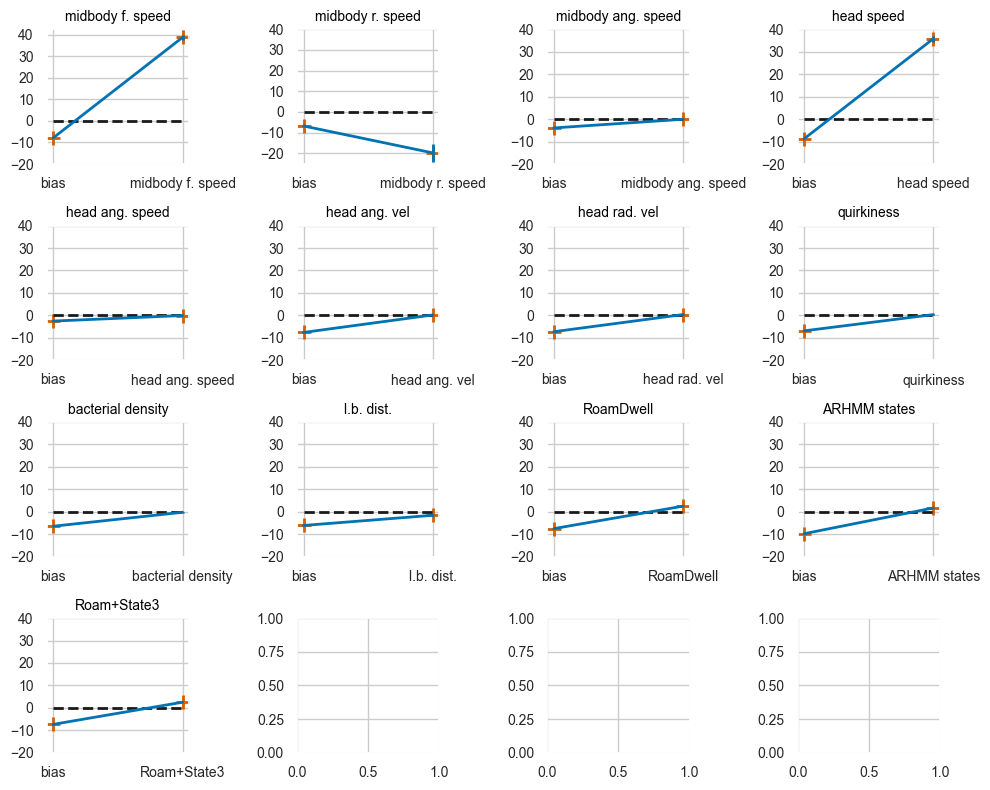

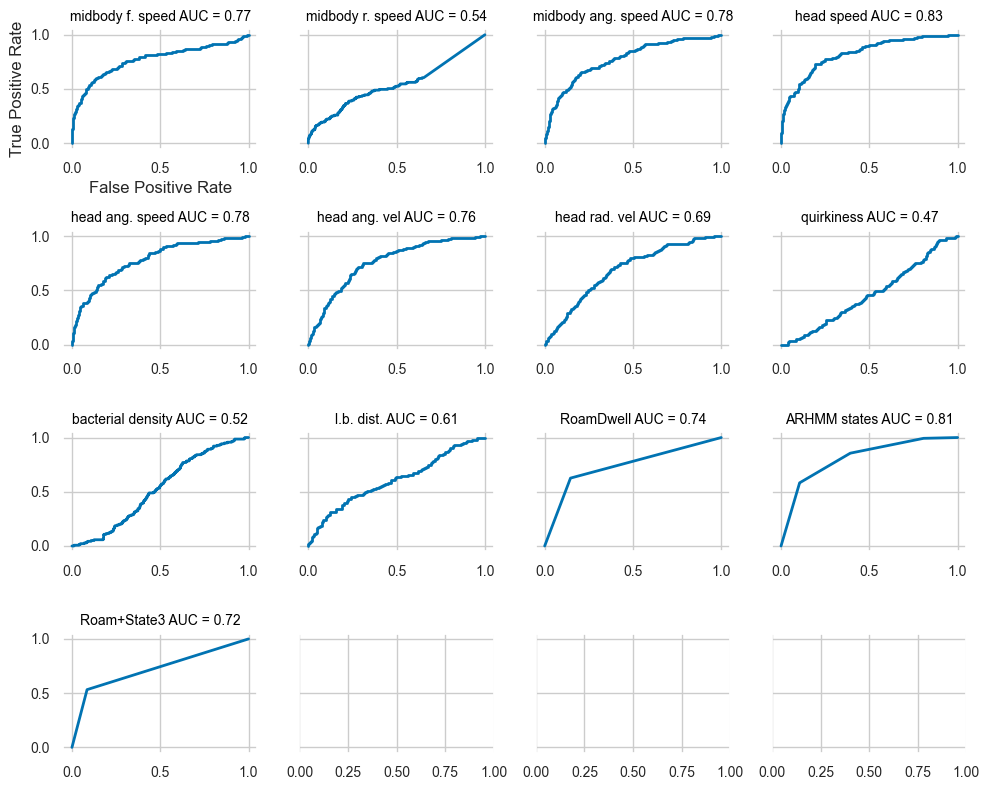

In [150]:
#plot weights for each GLM (1 param + bias for each) - LOGIT MODELS
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

featureLabels = ['midbody f. speed','midbody r. speed','midbody ang. speed','head speed','head ang. speed','head ang. vel','head rad. vel','quirkiness','bacterial density', 'l.b. dist.','RoamDwell','ARHMM states','Roam+State3']
fig,axs = plt.subplots(4,4,figsize=(10,8),sharey=False)
axs = axs.ravel()
for i in range(Obs_forGLM[0].shape[1]):
    axs[i].errorbar(np.arange(2),singleParam_GLMs_logit[i].params,yerr = singleParam_GLMs_logit[i].bse)
    sigIdx = singleParam_GLMs_logit[i].pvalues<0.05
    axs[i].scatter(np.where(sigIdx)[0],singleParam_GLMs_logit[i].params[sigIdx].to_numpy(),marker='+',color='r')
    axs[i].hlines(0,xmin=0,xmax=len(singleParam_GLMs_logit[i].params)-1,colors='k',linestyles='--')
    axs[i].set_yticks(np.arange(-20,41,10))
    axs[i].set_xticks([0,1])
    axs[i].set_xticklabels(['bias',featureLabels[i]],rotation=0)
    axs[i].set_title(featureLabels[i],fontsize=10)
    for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()): label.set_fontsize(10)
        
outpath = os.path.join(subfolder,varLabel+'_singleparamGLMlogit_weights'+'_'+datestring+'.pdf')
plt.savefig(outpath)#,dpi=300)

#generate ROC curves for each GLM on test data
from sklearn import metrics
fig,axs = plt.subplots(4,4,figsize=(10,8),sharey=True)
axs = axs.ravel()
for i in range(Obs_forGLM[0].shape[1]):
    allObs_test = pd.DataFrame(np.vstack(Obs_test_forGLM)[:,i], columns=[featureLabels[i]])                                  
    X_test = sm.add_constant(allObs_test) #add back the bias
    Y_test = np.vstack(Leaving_test_forGLM)                                
    Y_pred = singleParam_GLMs_logit[i].predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,Y_pred,pos_label=1)
    axs[i].plot(fpr,tpr)
    if i==0:
        axs[i].set_xlabel("False Positive Rate",fontsize=12)
        axs[i].set_ylabel("True Positive Rate",fontsize=12)
    axs[i].set_title(featureLabels[i]+" AUC = "+str(np.round(metrics.auc(fpr, tpr),2)),fontsize=10)

outpath = os.path.join(subfolder,varLabel+'_singleparamGLMlogit_ROCcurves'+'_'+datestring+'.pdf')
plt.savefig(outpath)#,dpi=300)
